# Summary of Key Takeaways

## Cluster characteristics summary
- Clusters 1 and 5 are the high spenders with high income.  Cluster 1 consists of loyalty customers but Cluster 5 customers spend the most per day.  They are similar in most key dimensions, with Cluster 1 being slightly better educated, having more children, and having slightly higher likelihood of having a  partner.  
- Clusters 0-2 are the loyalty customers and Clusters 3-5 are the newer customers. 
- Cluster 1 customers also have higher than average income, but probably have less disposable income due to having children
- Clusters 2-4 have lower income, are more likely to have children, and spend less

- Cluster 5 spends over 4% of their income at the store while Clusters 0 and 1 spend just over 2%. 


## Takeaways summary
- If run deals, target these at Clusters 2-4 
- Concentrate on making/keeping the web page appealing for Clusters 0, 1, and 5
- Make sure to have a polished catalog, especially for Cluster 5 customers, who could bring in the most revenue in the future
- Make customers’ in-store experience customers pleasant as high-spending clusters seem to value it
- Learn from Campaign 2 in order to not repeat it
- Concentrate on running and improving campaigns like Campaign1 and 5, as these attract the high-spending customers
- Concentrate on identifying and attracting customers like Cluster 5 for highest future expected revenue
- Look for ways to attract customers away from the alternatives.

## Future work
- It would be helpful to have more information about the data set and the store in order to answer the following questions:
 - What do we know about the rationale behind each campaign? What distinguishes the campaigns?
 - What more can we learn about our customers? Specifically, are there factors that differentiate Cluster 5 that are not in the data?
 - What else can be learned about the way the store is making customers in-store and online shopping experience pleasant? Are there way to improve?
 - Can the store learn to do profitable business with Cluster 2-4?
 - Get more granular data
 - Get more data on profitability rather than just revenue. Profitability is probably the company's main objective
 - Do A/B testing to judge the effectiveness of recommendations


- **Please see the work below for reasons behind these conclusions and recommendations**

# KMeans Clustering

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#import plotly.express as px

In [2]:
df = pd.read_csv('./data/marketing_data.csv')
#Preprocess Income
df['Income']=df[' Income ']
df['Income']=df.Income.str.replace('$','')
df['Income']=df.Income.str.replace(',','')#.astype("Int64")
df['Income']=df.Income.astype("float")
df['Income'].fillna((df['Income'].median()), inplace=True)
df = df.drop([' Income '], axis=1)
df.drop(df.index[[527,513,827,2233]],inplace=True) #drop income outlier 527 and age outliers
df['LogIncome'] = np.log1p(df['Income'])

#Preprocess Education
df.loc[df['Education']=='2n Cycle','Education']='Master'
df.loc[df['Education']=='Graduation','Education']='Bachelor'

#Preprocess Children
df['NumChildren']  = df['Kidhome']+df['Teenhome']
df['HasChildren']=np.where(df.NumChildren> 0, 1, 0)

#Preprocess Marital Status
df['HasPartner']=np.where(((df.Marital_Status== 'Married')|(df.Marital_Status== 'Together')), 1, 0)

#Preprocess Date and Make Age
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
df['age'] = 2014 - df['Year_Birth']

#Make total spending, num promotions, and num orders accepted columns
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] +\
        +df['MntSweetProducts'] + df['MntGoldProds']
df['AcceptedCmpTot']=df['AcceptedCmp1']+ df['AcceptedCmp2']+ df['AcceptedCmp3']+ df['AcceptedCmp4']+\
       + df['AcceptedCmp5']
df['NumTotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases']+df['NumCatalogPurchases']+\
    df['NumStorePurchases']+df['NumWebVisitsMonth']

# Make a column for spending normalized by length customer -> Consider doing this for other amounts as well
latest_date=(df["Dt_Customer"] + pd.to_timedelta(df['Recency'],'d')).max()
df['Len_Customer']=latest_date - df["Dt_Customer"]
df['Len_Customer']=df['Len_Customer'] / pd.to_timedelta(1, unit='D') #Convert to float
df['MntSpentNorm']=df['MntTotal']/df['Len_Customer']

In [3]:
df[df.age>100]

,ID,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,LogIncome,NumChildren,HasChildren,HasPartner,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm


In [4]:
df[df.Income>300000]

,ID,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,LogIncome,NumChildren,HasChildren,HasPartner,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm


In [5]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'HasPartner', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm'],
      dtype='object')

In [6]:
cats = {'Education', 'Marital_Status', 
       'Kidhome', 'Teenhome','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain','Country','HasChildren','HasPartner',}
# for var in cats:
#     df[var] = df[var].astype('category').cat.codes


nums = (set(df.columns) -set(cats)) - {'ID','Dt_Customer','LogIncome','MntSpentNorm','MntTotal', 'AcceptedCmpTot','NumTotalPurchases','Year_Birth'} #drop some highly correlated transformed vars

#X = df.drop(list(nums),axis=1) #Dropping Dt_Customer since this is causing problems in RF
X = df[list(nums)] #Dropping Dt_Customer since this is causing problems in RF

In [7]:
pd.set_option('display.max_columns', 500)

In [8]:
X.head()

,MntFishProducts,NumDealsPurchases,NumCatalogPurchases,Recency,NumStorePurchases,MntGoldProds,Len_Customer,MntMeatProducts,Income,MntFruits,MntWines,age,NumWebVisitsMonth,NumChildren,MntSweetProducts,NumWebPurchases
0,111,1,4,0,6,218,110.0,379,84835.0,104,189,44,1,0,189,4
1,7,1,3,0,7,37,111.0,64,57091.0,5,464,53,5,0,0,7
2,15,1,2,0,5,30,144.0,59,67267.0,11,134,56,2,1,2,3
3,0,1,0,0,2,0,146.0,1,32474.0,0,10,47,7,2,0,1
4,11,2,1,0,2,34,179.0,24,21474.0,16,6,25,7,1,0,3


In [9]:
np.shape(X)

(2236, 16)

- The data has meaningful mild outliers we wish to preserve, so choose to use the MinMaxScaler rather than StandardScaler, which would 'force' the data to obey a normal distribution

In [10]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

In [11]:
num_components=np.shape(X)[1]

## KMeans description
- From a high level, our KMeans algorithm follows the below steps in order to find optimal cluster groups:

1. Select k as the number of groups to cluster for
2. Randomly pick k points in our data as centroid points
3. Assign each non-centroid point to its closest centroid
4. Recalculate centroid points by taking the average of all surrounding points assigned to that cluster
5. Repeat steps 3-4 until calculated centroid points do not move anymore. Done
- Source: https://philippeheitzmann.com/2022/01/implementing-kmeans-clustering/

Elbow Method:


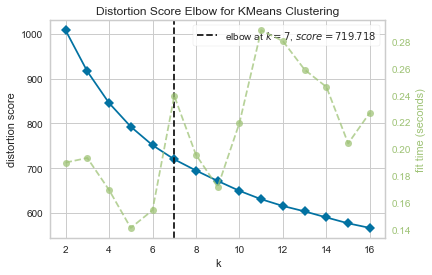

In [12]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method:')
Elbow_M = KElbowVisualizer(KMeans(), k=num_components, random_seed=42) #for the 20 numeric
Elbow_M.fit(data_rescaled) 
Elbow_M.show();

- Based on the elbow method, use 6 clusters. I also tried the silhouette method, which gave ambiguous results.

## KMeans results

In [13]:
n_clusters=6

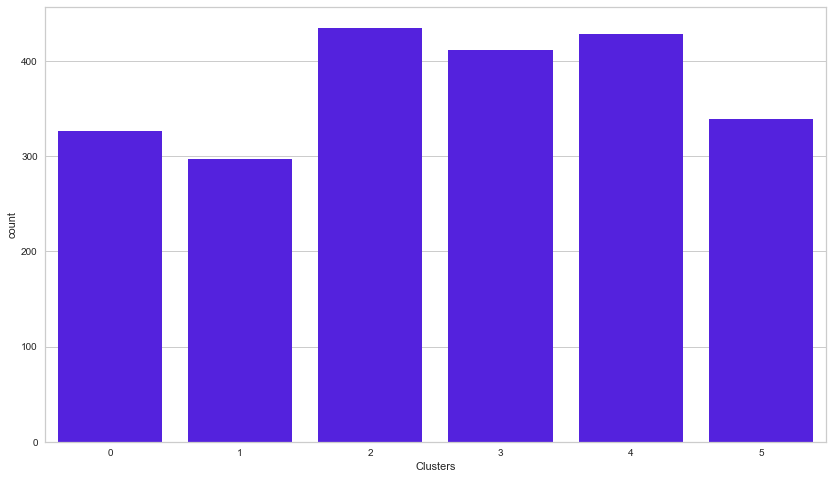

In [14]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Clusters'] = kmeans.fit_predict(data_rescaled)

# data_rescaled = pd.DataFrame(data_rescaled, columns = nums)

# data_rescaled['Clusters'] = df["Clusters"]

plt.figure(figsize=(14, 8))
sns.countplot(x='Clusters', data=df,hue=None,color='#4503fc',)
plt.show()

In [15]:
df.Clusters.value_counts()

2    435
4    428
3    411
5    339
0    326
1    297
Name: Clusters, dtype: int64

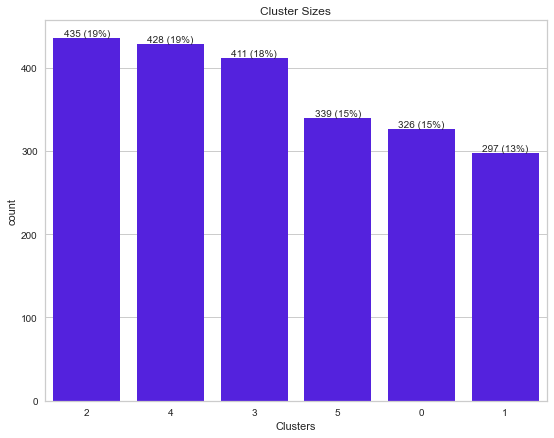

In [16]:
# Code hint from https://stackoverflow.com/questions/49044131/how-to-add-data-labels-to-seaborn-countplot-factorplot
plt.figure(figsize=(9, 7))

ax = sns.countplot(x=df['Clusters'], data=df,hue=None,color='#4503fc',order=df['Clusters'].value_counts(ascending=False).index);
        
abs_values = df['Clusters'].value_counts(ascending=False)
rel_values = df['Clusters'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
ax.set_title("Cluster Sizes")

plt.savefig('./figures/clusters_sizes.png')


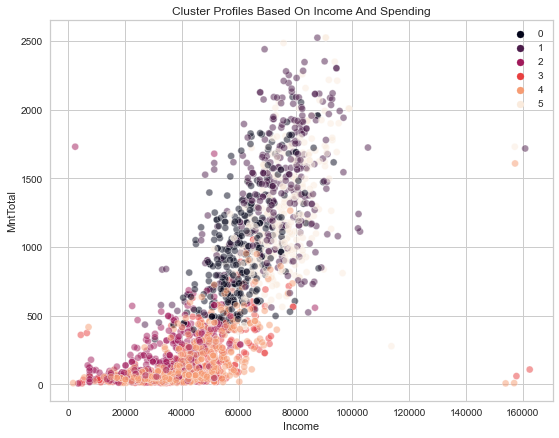

In [17]:
plt.figure(figsize=(9, 7))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster Profiles Based On Income And Spending")
plt.savefig('./figures/income_mnttotal_clusters.pdf')#, bbox_inches='tight')
plt.legend()
plt.show()

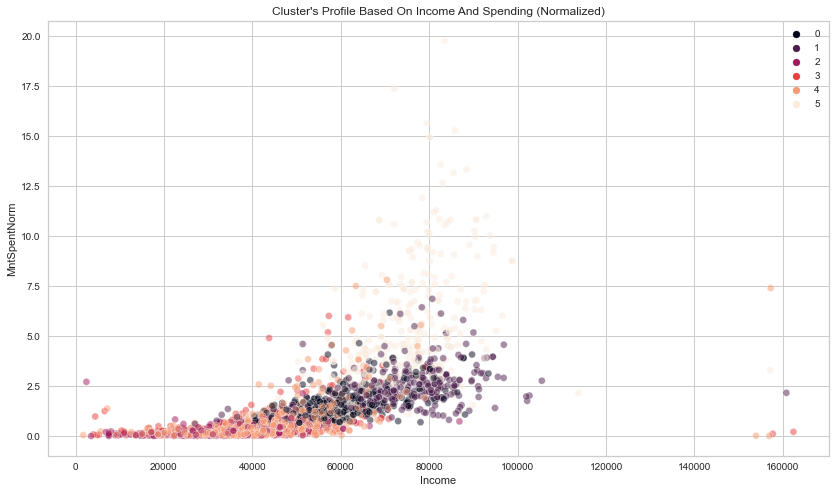

In [18]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)

plot.set_title("Cluster's Profile Based On Income And Spending (Normalized)")
plt.legend()
plt.show()

In [19]:
df["Clusters"].value_counts()

2    435
4    428
3    411
5    339
0    326
1    297
Name: Clusters, dtype: int64

<AxesSubplot:>

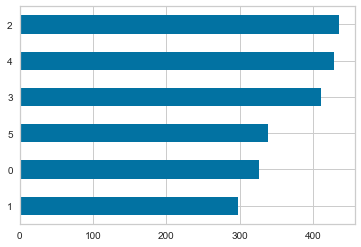

In [20]:
df.Clusters.value_counts().sort_values().plot(kind = 'barh')

- NOTE: Another approach to scaling would be to take the logs of the columns with the long tails before using MinMaxScaler.  When I did it in one of the experimental notebooks (002_Segmentation_and_Takeaways-Logged-Columns.ipynb), I got similar results with regards to clustering and reversal in spending between the two wealthier clusters.  The clusters were numbered differently, so I chose not to rewrite the conlcusions in view of different numbering. 

## Identify cluster characteristics based on demographic factors and contribution to total revenue

In [21]:
groupsKmeans=df.groupby(['Clusters'])#.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

In [22]:
groupsKmeans.agg(['count', 'sum', 'min', 'max', 'mean', 'std'])

ID                                               Year_Birth  \
         count      sum min    max         mean          std      count   
Clusters                                                                  
0          326  1733528  17  11088  5317.570552  3276.845904        326   
1          297  1663464   0  11112  5600.888889  3191.683766        297   
2          435  2522623   9  11187  5799.133333  3258.873936        435   
3          411  2344066   1  11191  5703.323601  3287.676399        411   
4          428  2316039  13  11188  5411.306075  3216.940225        428   
5          339  1917303  75  11101  5655.761062  3219.606037        339   

                                                     Kidhome               \
             sum   min   max         mean        std   count  sum min max   
Clusters                                                                    
0         640083  1943  1991  1963.444785   9.271380     326   76   0   2   
1         584753  1941  1995  1968.865320  13.058938     297    8   0   1   
2         858147  1946  1996  1972.751724  10.974120     435  306   0   2   
3         809879  1945  1992  1970.508516  10.708638     411  284   0   2   
4         842387  1940  1996  1968.193925  11.090315     428  304   0   2   
5         667207  1943  1995  1968.162242  13.131794     339   15   0   2   

                             Teenhome                                   \
              mean       std    count  sum min max      mean       std   
Clusters                                                                 
0         0.233129  0.437764      326  307   0   2  0.941718  0.407214   
1         0.026936  0.162170      297   57   0   2  0.191919  0.402948   
2         0.703448  0.495939      435  183   0   2  0.420690  0.521461   
3         0.690998  0.535921      411  228   0   2  0.554745  0.535378   
4         0.710280  0.556155      428  274   0   2  0.640187  0.561423   
5         0.044248  0.219846      339   84   0   2  0.247788  0.439155   

         Recency                                      MntWines               \
           count    sum min max       mean        std    count     sum  min   
Clusters                                                                      
0            326  16380   0  99  50.245399  27.075982      326  211267  115   
1            297  16716   1  99  56.282828  28.589135      297  178460    7   
2            435  20423   0  99  46.949425  26.278326      435   32042    0   
3            411   9084   0  53  22.102190  14.638048      411   36104    0   
4            428  32829  48  99  76.703271  14.331253      428   40045    0   
5            339  14392   0  99  42.454277  27.748023      339  182111    1   

                                       MntFruits                             \
           max        mean         std     count    sum min  max       mean   
Clusters                                                                      
0         1492  648.058282  313.523087       326   7845   0  142  24.064417   
1         1493  600.875421  302.747254       297  22824   0  199  76.848485   
2          462   73.659770   91.330736       435   3350   0   77   7.701149   
3          738   87.844282  132.988098       411   2094   0   60   5.094891   
4          934   93.563084  131.792215       428   2564   0   70   5.990654   
5         1478  537.200590  304.837625       339  20076   0  197  59.221239   

                    MntMeatProducts                                            \
                std           count     sum min   max        mean         std   
Clusters                                                                        
0         26.470631             326   56425  21   650  173.082822  108.917623   
1         49.813306             297  139282  64  1622  468.962963  256.208837   
2         11.114729             435   20009   1  1725   45.997701  118.077681   
3          8.238414             411   12134   0   257   29.523114

In [23]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,HasPartner,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,5589.008497,1968.898032,0.444097,0.506708,49.116279,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873,0.072898,0.074687,0.072451,0.064401,0.013417,0.149374,0.008945,51952.614043,10.753375,0.950805,0.715116,0.644902,45.101968,605.986583,0.297853,20.191413,450.773256,1.653348,2.597048
std,3244.826887,11.703281,0.538459,0.544609,28.957284,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886,0.260027,0.262944,0.259291,0.245520,0.115077,0.356536,0.094173,21411.466851,0.500319,0.752204,0.451460,0.478650,11.703281,601.865156,0.678737,7.291811,202.181561,2.173188,1.635449
min,0.000000,1940.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2828.250000,1959.000000,0.000000,0.000000,24.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35502.500000,10.477386,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.750000,0.202060,1.000000
50%,5454.500000,1970.000000,0.000000,0.000000,49.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,1.000000,44.000000,396.500000,0.000000,19.000000,453.000000,0.866443,3.000000
75%,8421.750000,1977.000000,1.000000,1.000000,74.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68275.750000,11.131325,1.000000,1.000000,1.000000,55.000000,1045.500000,0.000000,25.000000,626.000000,2.270000,4.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,74.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,5.000000


- Figure out how much each cluster spends

[316631.0, 423166.0, 76797.0, 62794.0, 73775.0, 401823.0]
['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']


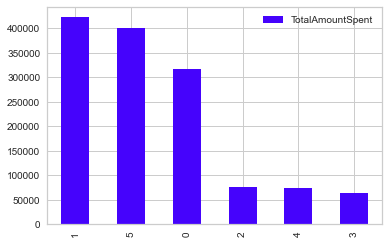

In [24]:
cluster_mnt_totals = [[]]*n_clusters

for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntTotal.mean()*len(cluster_i)

print(cluster_mnt_totals) 

columns = ['cluster'+str(i) for i in range(n_clusters)]
print(columns)

df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'TotalAmountSpent'},axis=1)

df_cluster_mnt_totals.sort_values('TotalAmountSpent', ascending=False).plot.bar(color='#4503fc')
plt.savefig('./figures/total_spent.png')


[562.0356274816252, 720.5741168756956, 117.4872710272772, 258.1228113801819, 291.3546628249603, 1747.3114942843993]
['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']


<AxesSubplot:>

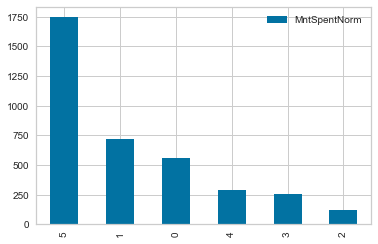

In [25]:
cluster_mnt_totals = [[]]*n_clusters

for i in range(n_clusters):
    cluster_i=df[df["Clusters"]==i]
    cluster_mnt_totals[i] = cluster_i.MntSpentNorm.mean()*len(cluster_i)

print(cluster_mnt_totals) 

columns = ['cluster'+str(i) for i in range(n_clusters)]
print(columns)

df_cluster_mnt_totals = pd.DataFrame([cluster_mnt_totals], columns = ['cluster'+str(i) for i in range(n_clusters)])

df_cluster_mnt_totals=df_cluster_mnt_totals.T.reset_index().rename({0:'MntSpentNorm'},axis=1)

df_cluster_mnt_totals.sort_values('MntSpentNorm', ascending=False).plot.bar()

<!-- # Description of Customer Behavior
- Clusters 2 and 4 are big clusters that spend little
- Clusters 2 and 4  are usually educated, relatively recent customers, but are much more likely to have children than Clusters 1 and 3. Perhaps this store focuses on high-end more expensive products (Whole Foods at Monterey?) and people with children are finding it harder to afford shopping there, on average.  Cluster 5 customers have about just as likely to have children as Clusters 2 and 4, yet have a higher income.  
- To confirm these findings, Clusters 2, 4, and 5 are making the most deal purchases, especially when these are normalized by length someone spend as a customer.
 -->

- Cluster 5, 1, and 0 contribute to revenue  the most

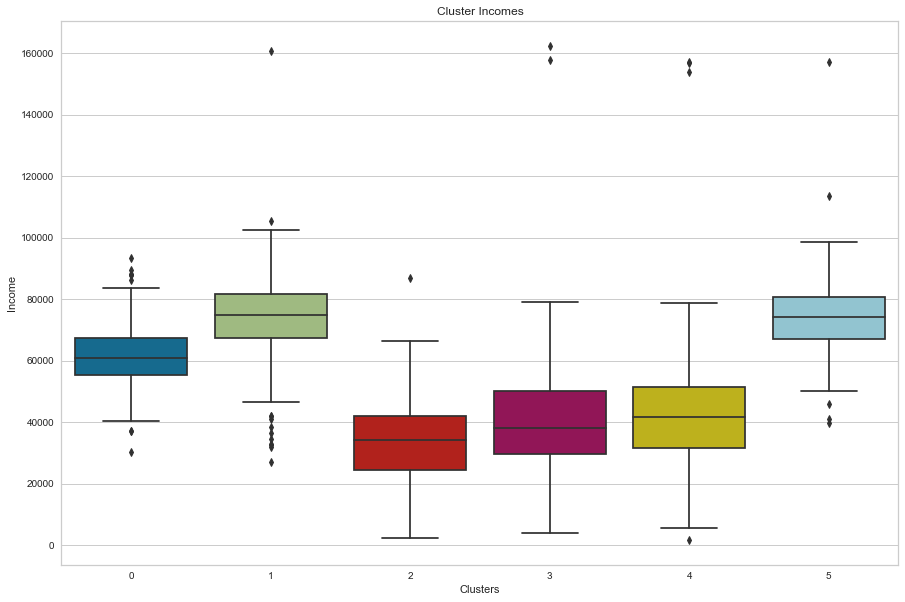

In [26]:
plt.figure(figsize=(15, 10))
palette=sns.color_palette("rocket", as_cmap=True)

plot=sns.boxplot(x="Clusters", y="Income",
            data=df)

plot.set_title("Cluster Incomes")
plt.savefig('./figures/income_clusters_box.png')
plt.show()

In [27]:
df.describe()

,ID,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Income,LogIncome,NumChildren,HasChildren,HasPartner,age,MntTotal,AcceptedCmpTot,NumTotalPurchases,Len_Customer,MntSpentNorm,Clusters
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.00000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,5589.008497,1968.898032,0.444097,0.506708,49.116279,304.12746,26.275939,166.983453,37.536225,27.080501,43.983005,2.326029,4.087657,2.663238,5.795617,5.318873,0.072898,0.074687,0.072451,0.064401,0.013417,0.149374,0.008945,51952.614043,10.753375,0.950805,0.715116,0.644902,45.101968,605.986583,0.297853,20.191413,450.773256,1.653348,2.597048
std,3244.826887,11.703281,0.538459,0.544609,28.957284,336.59181,39.724007,225.689645,54.648562,41.299504,52.061568,1.933032,2.779988,2.923898,3.251129,2.426886,0.260027,0.262944,0.259291,0.245520,0.115077,0.356536,0.094173,21411.466851,0.500319,0.752204,0.451460,0.478650,11.703281,601.865156,0.678737,7.291811,202.181561,2.173188,1.635449
min,0.000000,1940.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,7.456455,0.000000,0.000000,0.000000,18.000000,5.000000,0.000000,0.000000,97.000000,0.009276,0.000000
25%,2828.250000,1959.000000,0.000000,0.000000,24.000000,24.00000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35502.500000,10.477386,0.000000,0.000000,0.000000,37.000000,69.000000,0.000000,14.000000,277.750000,0.202060,1.000000
50%,5454.500000,1970.000000,0.000000,0.000000,49.000000,174.00000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51381.500000,10.847053,1.000000,1.000000,1.000000,44.000000,396.500000,0.000000,19.000000,453.000000,0.866443,3.000000
75%,8421.750000,1977.000000,1.000000,1.000000,74.000000,504.25000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68275.750000,11.131325,1.000000,1.000000,1.000000,55.000000,1045.500000,0.000000,25.000000,626.000000,2.270000,4.000000
max,11191.000000,1996.000000,2.000000,2.000000,99.000000,1493.00000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,162397.000000,11.997805,3.000000,1.000000,1.000000,74.000000,2525.000000,4.000000,46.000000,796.000000,19.788991,5.000000


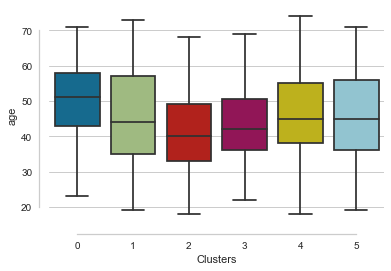

In [28]:
sns.boxplot(x="Clusters", y="age",
            data=df)
sns.despine(offset=10, trim=True)

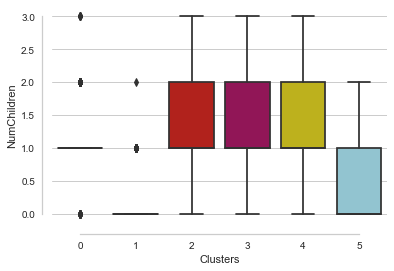

In [29]:
sns.boxplot(x="Clusters", y="NumChildren",
            data=df)
sns.despine(offset=10, trim=True)

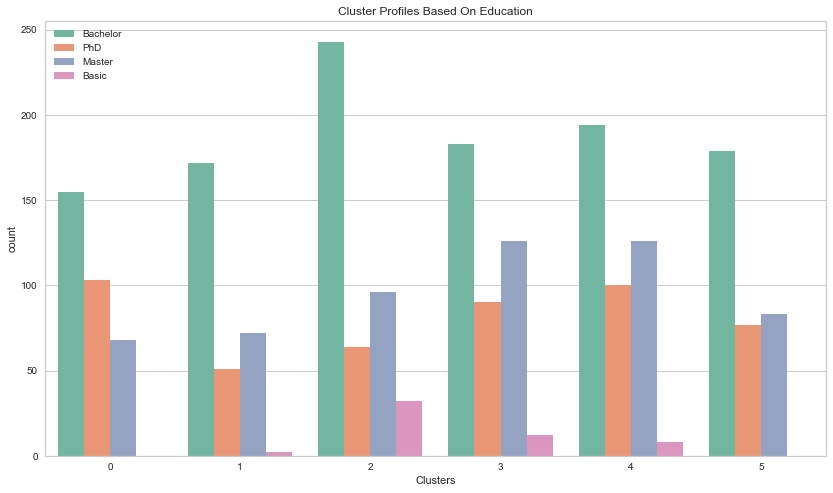

In [30]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("Set2")
plot = sns.countplot(x=df["Clusters"],hue=df["Education"], palette = palette)

plot.set_title("Cluster Profiles Based On Education")
plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


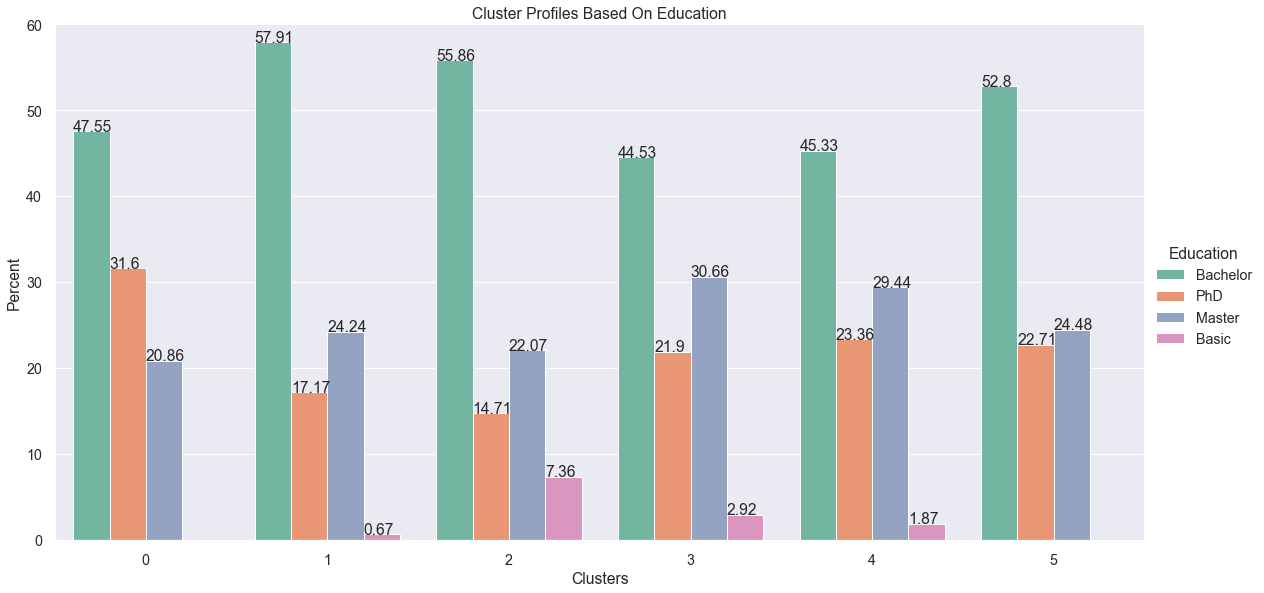

In [31]:
#plt.figure(figsize=(14,8)) #does not work, use height and aspect
palette=sns.color_palette("Set2")
sns.set(font_scale = 1.3)

x,y = 'Clusters', 'Education'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()

g = sns.catplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette,height=8,aspect=2)
#g.figure(figsize=(14,8))

g.ax.set_ylim(0,60)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) #+ '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    #plt.figure(figsize=(14,8))
    #plt.figure(figsize=(14,8))
plt.title("Cluster Profiles Based On Education")
plt.savefig('./figures/edu_clusters.png')

- Cluster 5 are more highly educated than Cluster 1

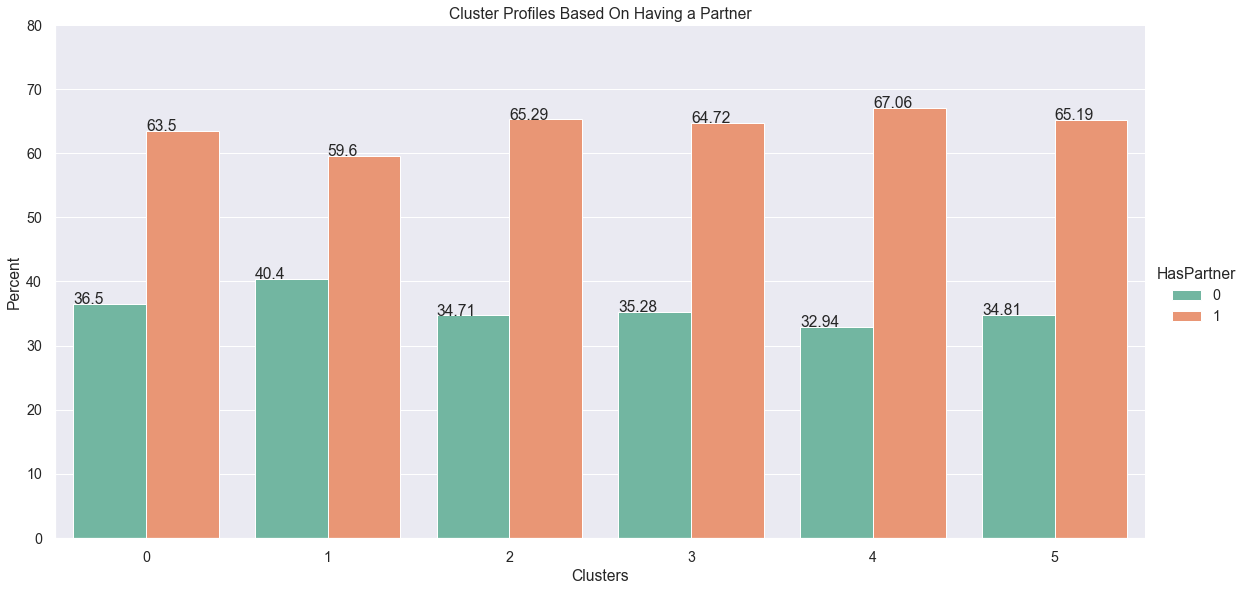

In [32]:
#plt.figure(figsize=(14,8)) #does not work, use height and aspect
palette=sns.color_palette("Set2")
sns.set(font_scale = 1.3)

x,y = 'Clusters', 'HasPartner'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()

g = sns.catplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette,height=8,aspect=2)
#g.figure(figsize=(14,8))

g.ax.set_ylim(0,80)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) #+ '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    #plt.figure(figsize=(14,8))
    #plt.figure(figsize=(14,8))
plt.title("Cluster Profiles Based On Having a Partner")
plt.savefig('./figures/partner_clusters.png')

- Cluster 5 are slightly more likely to have a partner than Cluster 1

In [33]:
groupsKmeansEdu=df.groupby(['Clusters','Education']).agg(['count'])

In [34]:
groupsKmeansEdu

ID Year_Birth Marital_Status Kidhome Teenhome  \
                   count      count          count   count    count   
Clusters Education                                                    
0        Bachelor    155        155            155     155      155   
         Master       68         68             68      68       68   
         PhD         103        103            103     103      103   
1        Bachelor    172        172            172     172      172   
         Basic         2          2              2       2        2   
         Master       72         72             72      72       72   
         PhD          51         51             51      51       51   
2        Bachelor    243        243            243     243      243   
         Basic        32         32             32      32       32   
         Master       96         96             96      96       96   
         PhD          64         64             64      64       64   
3        Bachelor    183        183            183     183      183   
         Basic        12         12             12      12       12   
         Master      126        126            126     126      126   
         PhD          90         90             90      90       90   
4        Bachelor    194        194            194     194      194   
         Basic         8          8              8       8        8   
         Master      126        126            126     126      126   
         PhD         100        100            100     100      100   
5        Bachelor    179        179            179     179      179   
         Master       83         83             83      83       83   
         PhD          77         77             77      77       77   

                   Dt_Customer Recency MntWines MntFruits MntMeatProducts  \
                         count   count    count     count           count   
Clusters Education                                                          
0        Bachelor          155     155      155       155             155   
         Master             68      68       68        68              68   
         PhD               103     103      103       103             103   
1        Bachelor          172     172      172       172             172   
         Basic               2       2        2         2               2   
         Master             72      72       72        72              72   
         PhD                51      51       51        51              51   
2        Bachelor          243     243      243       243             243   
         Basic              32      32       32        32              32   
         Master             96      96       96        96              96   
         PhD                64      64       64        64              64   
3        Bachelor          183     183      183       183             183   
         Basic              12      12       12        12              12   
         Master            126     126      126       126             126   
         PhD                90      90       90        90              90   
4        Bachelor          194     194      194       194             194   
         Basic               8       8        8         8               8   
         Master            126     126      126       126             126   
         PhD               100     100      100       100             100   
5        Bachelor          179     179      179       179             179   
         Master             83      83       83        83              83   
         PhD                77      77       77        77              77   

                   MntFishProducts MntSweetProducts MntGoldProds  \
                             count            count        count   
Clusters Education                                                 
0        Bachelor              155              155          155   
         Master                 68              

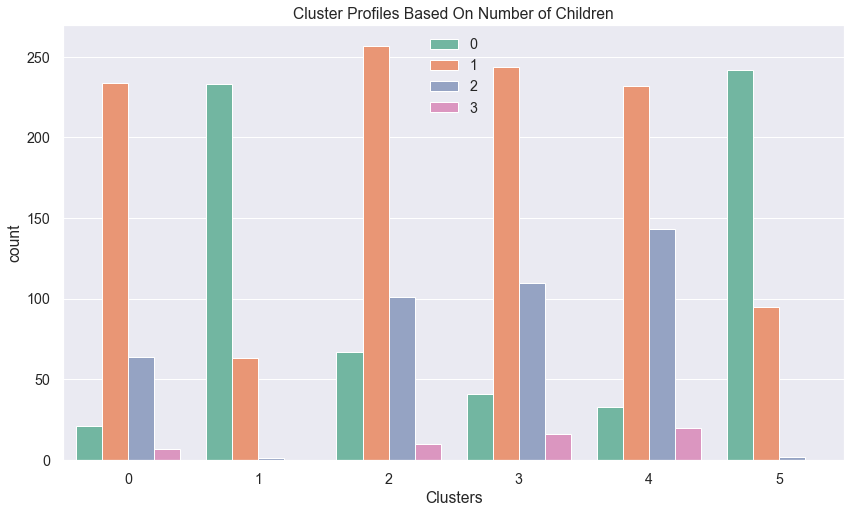

In [35]:
plt.figure(figsize=(14, 8))
palette=sns.color_palette("Set2")

#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Clusters"],hue=df["NumChildren"], palette = palette)

plot.set_title("Cluster Profiles Based On Number of Children")
plt.savefig('./figures/child_clusters.png')
plt.legend()
plt.show()

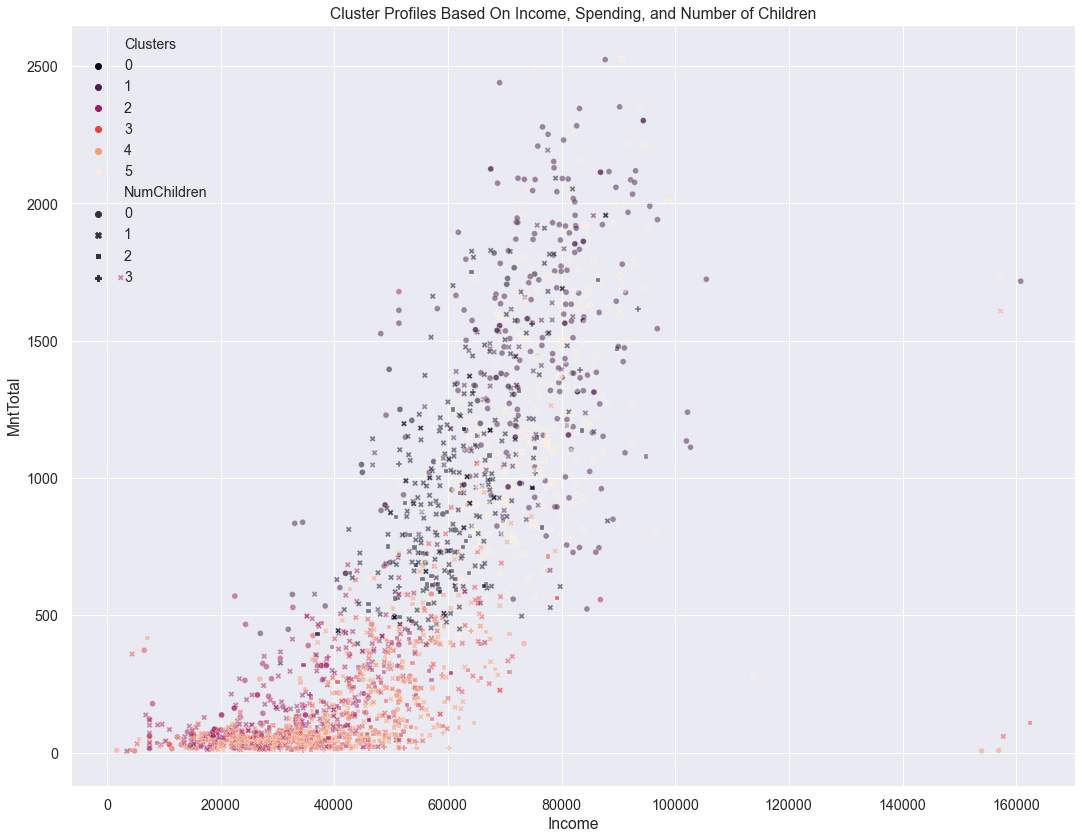

In [36]:
plt.figure(figsize=(18, 14))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Income"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette,style=df['NumChildren'])

plot.set_title("Cluster Profiles Based On Income, Spending, and Number of Children")
plt.savefig('./figures/income_mnttotal_child_clusters.pdf')#, bbox_inches='tight')
plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


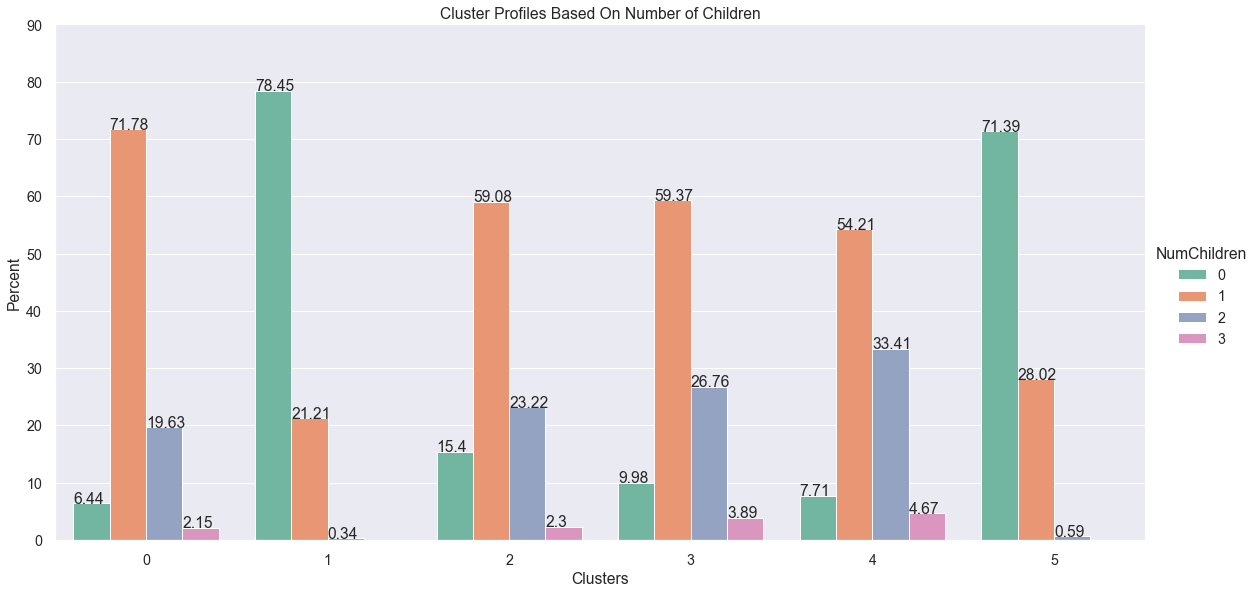

In [37]:
#plt.figure(figsize=(14,8)) #does not work, use height and aspect
sns.set(font_scale = 1.3)
palette=sns.color_palette("Set2")

x,y = 'Clusters', 'NumChildren'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()

g = sns.catplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette,height=8,aspect=2)
#g = sns.countplot(x=x,y='Percent',hue=y,kind='bar',data=df1,palette=palette,height=8,aspect=2)
#plot = sns.countplot(x=df["Clusters"],hue=df["NumChildren"], palette = palette)


#g.figure(figsize=(14,8))

g.ax.set_ylim(0,90)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) #+ '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    #plt.figure(figsize=(14,8))
    #plt.figure(figsize=(14,8))
plt.title('Cluster Profiles Based On Number of Children')

plt.savefig('./figures/child_clusters.png')

- Most customers in Clusters 1 and 5 don't have children, but Cluster 5 customers are likelier to have at least one child

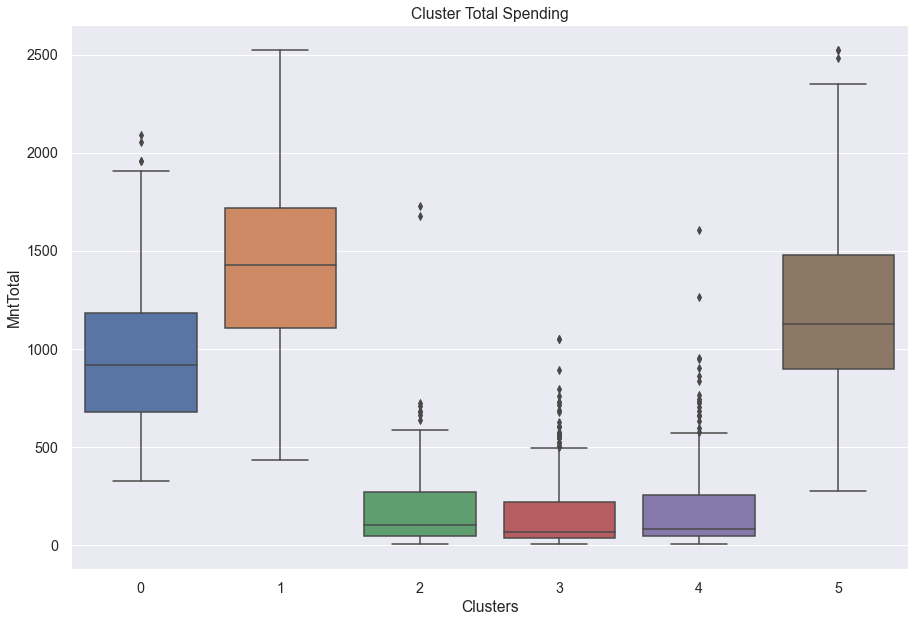

In [38]:
plt.figure(figsize=(15, 10))
palette=sns.color_palette("rocket", as_cmap=True)

plot=sns.boxplot(x="Clusters", y="MntTotal",
            data=df)

plot.set_title("Cluster Total Spending")
plt.savefig('./figures/mnttotal_clusters_box.png')
plt.show()

- Cluster 5 spent less total but more when normalized by length customer

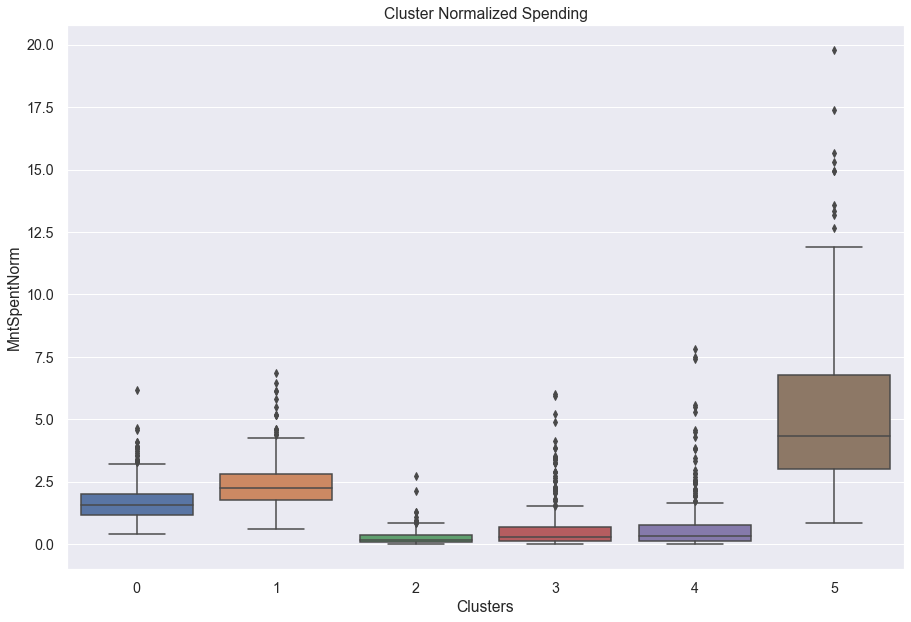

In [39]:
plt.figure(figsize=(15, 10))
palette=sns.color_palette("rocket", as_cmap=True)

plot=sns.boxplot(x="Clusters", y="MntSpentNorm",
            data=df)

plot.set_title("Cluster Normalized Spending")
plt.savefig('./figures/mnt_norm_clusters_box.png')
plt.show()

- Another look at Cluster 5 normalized spending

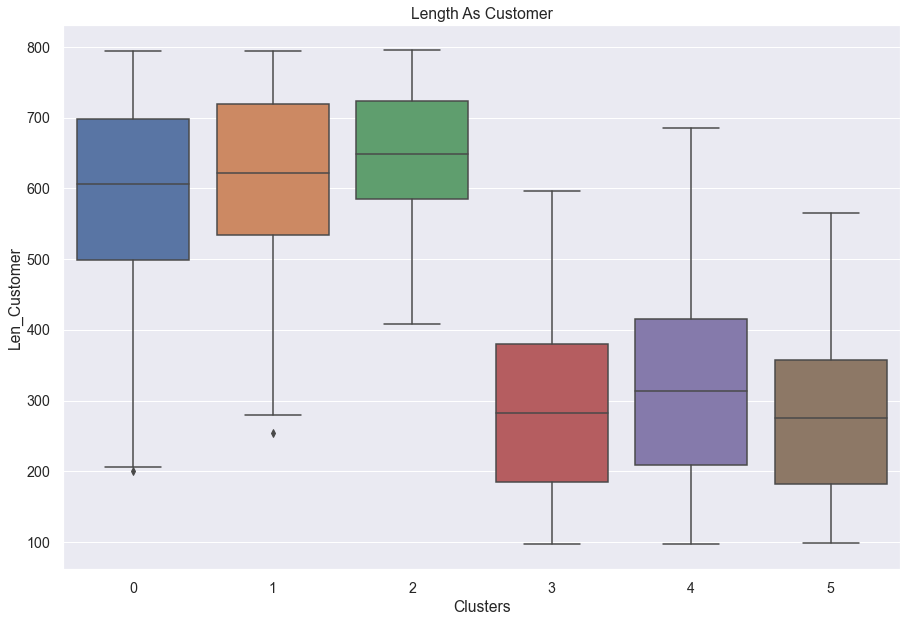

In [40]:
plt.figure(figsize=(15, 10))
palette=sns.color_palette("rocket", as_cmap=True)

plot=sns.boxplot(x="Clusters", y="Len_Customer",
            data=df)

plot.set_title("Length As Customer")
plt.savefig('./figures/length_customer_box.png')
plt.show()


- Clusters 3-5 are the recent customers and others are 'loyalty' customers

## See if the spending patterns persist when normalized

In [41]:
df['MntWinesNorm']=df['MntWines']/df['Len_Customer']

df['MntFruitsNorm']=df['MntFruits']/df['Len_Customer']

df['MntMeatProductsNorm']=df['MntMeatProducts']/df['Len_Customer']

df['MntFishProductsNorm']=df['MntFishProducts']/df['Len_Customer']

df['MntSweetProductsNorm']=df['MntSweetProducts']/df['Len_Customer']

df['MntGoldProdsNorm']=df['MntGoldProds']/df['Len_Customer']

df['NumDealsPurchasesNorm']=df['NumDealsPurchases']/df['Len_Customer']

df['NumWebPurchasesNorm']=df['NumWebPurchases']/df['Len_Customer']

df['NumStorePurchasesNorm']=df['NumStorePurchases']/df['Len_Customer']

df['NumWebVisitsMonthNorm']=df['NumWebVisitsMonth']/df['Len_Customer']

df['NumCatalogPurchasesNorm']=df['NumCatalogPurchases']/df['Len_Customer']

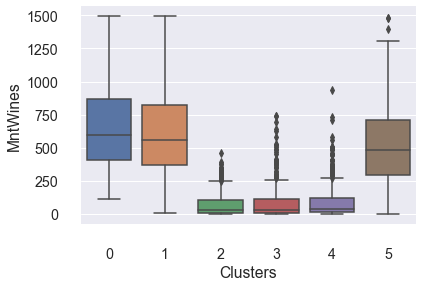

In [42]:
sns.boxplot(x="Clusters", y="MntWines",
            data=df)
sns.despine(offset=10, trim=True)

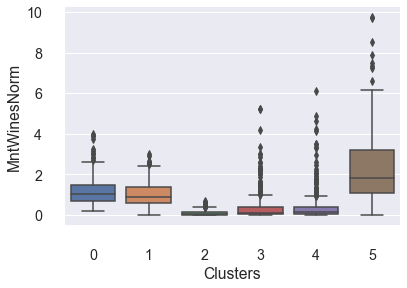

In [43]:
sns.boxplot(x="Clusters", y="MntWinesNorm",
            data=df)
sns.despine(offset=10, trim=True)

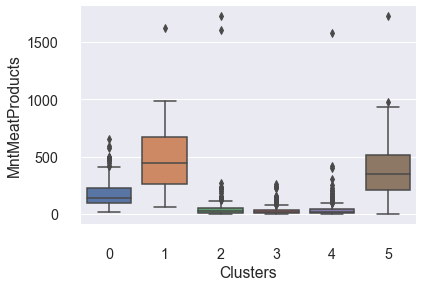

In [44]:
sns.boxplot(x="Clusters", y="MntMeatProducts",
            data=df)
sns.despine(offset=10, trim=True)

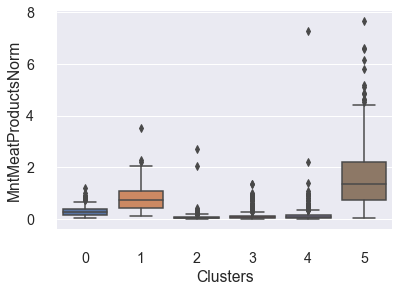

In [45]:
sns.boxplot(x="Clusters", y="MntMeatProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

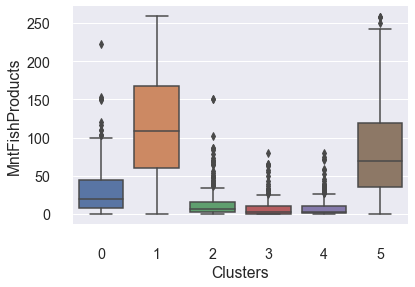

In [46]:
sns.boxplot(x="Clusters", y="MntFishProducts",
            data=df)
sns.despine(offset=10, trim=True)

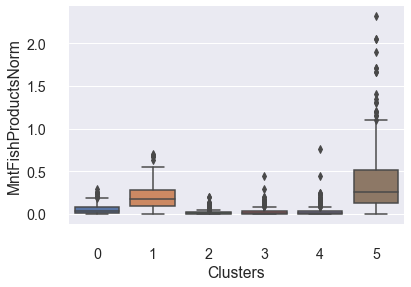

In [47]:
sns.boxplot(x="Clusters", y="MntFishProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

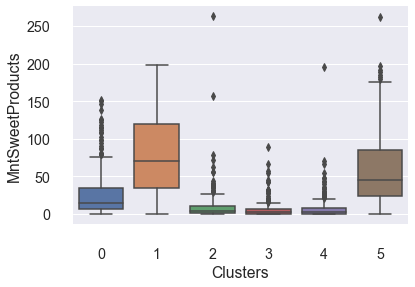

In [48]:
sns.boxplot(x="Clusters", y="MntSweetProducts",
            data=df)
sns.despine(offset=10, trim=True)

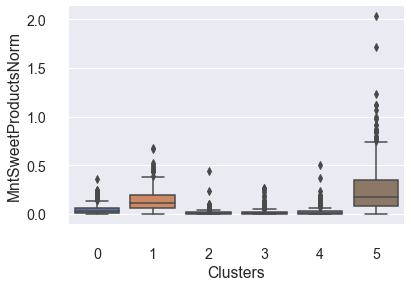

In [49]:
sns.boxplot(x="Clusters", y="MntSweetProductsNorm",
            data=df)
sns.despine(offset=10, trim=True)

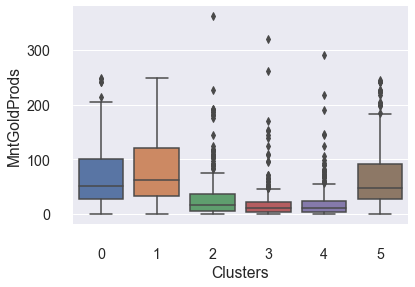

In [50]:
sns.boxplot(x="Clusters", y="MntGoldProds",
            data=df)
sns.despine(offset=10, trim=True)

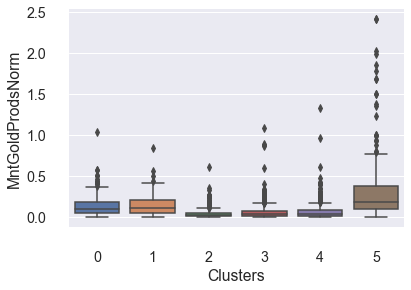

In [51]:
sns.boxplot(x="Clusters", y="MntGoldProdsNorm",
            data=df)
sns.despine(offset=10, trim=True)

- Yes, Clusters 5 and 1 are still the biggest spenders. Cluster 5 spend the most when normalized.

## Look at the number of deals accepted by cluster

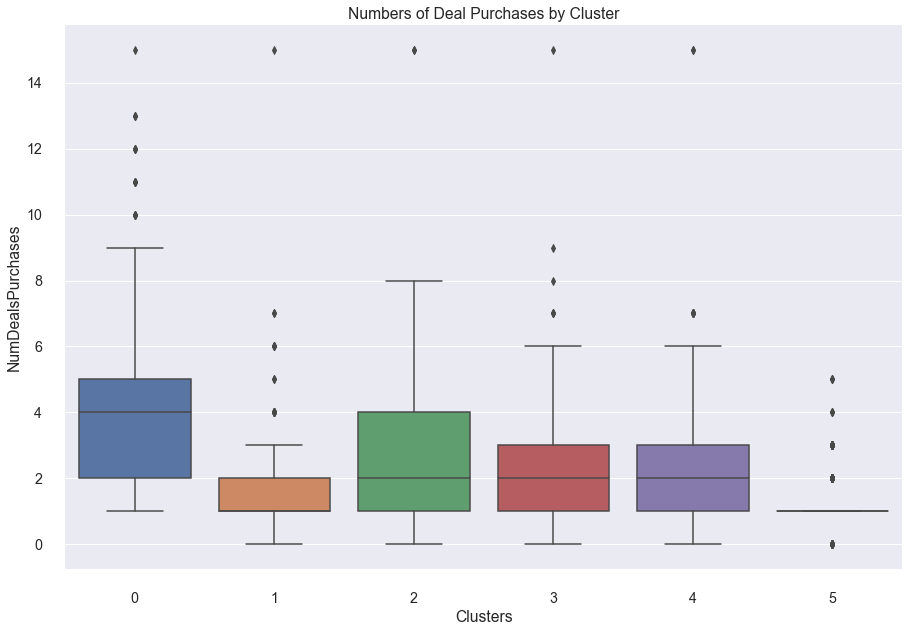

In [52]:
plt.figure(figsize=(15, 10))
plot=sns.boxplot(x="Clusters", y="NumDealsPurchases",
            data=df)
sns.despine(offset=10, trim=True)
plot.set_title("Numbers of Deal Purchases by Cluster")

plt.savefig('./figures/num_deals.png')

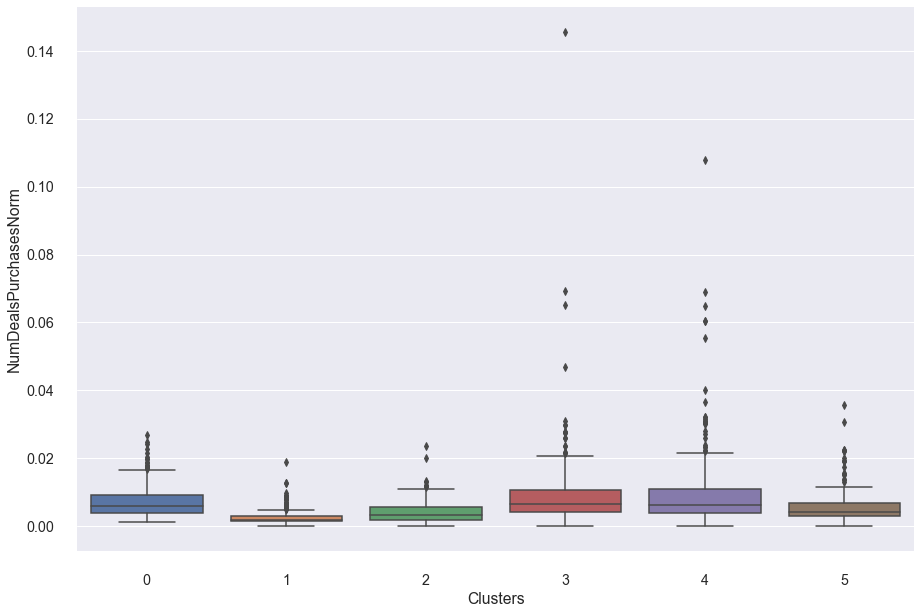

In [58]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="NumDealsPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)
plot.set_title("Numbers of Deal Purchases by Cluster (Normalized)")

plt.savefig('./figures/num_deals_norm.png')

- Target the deals primarily at Cluster 0, but also at clusters 3 and 4

## Look at the number of web, catalog, and store purchases

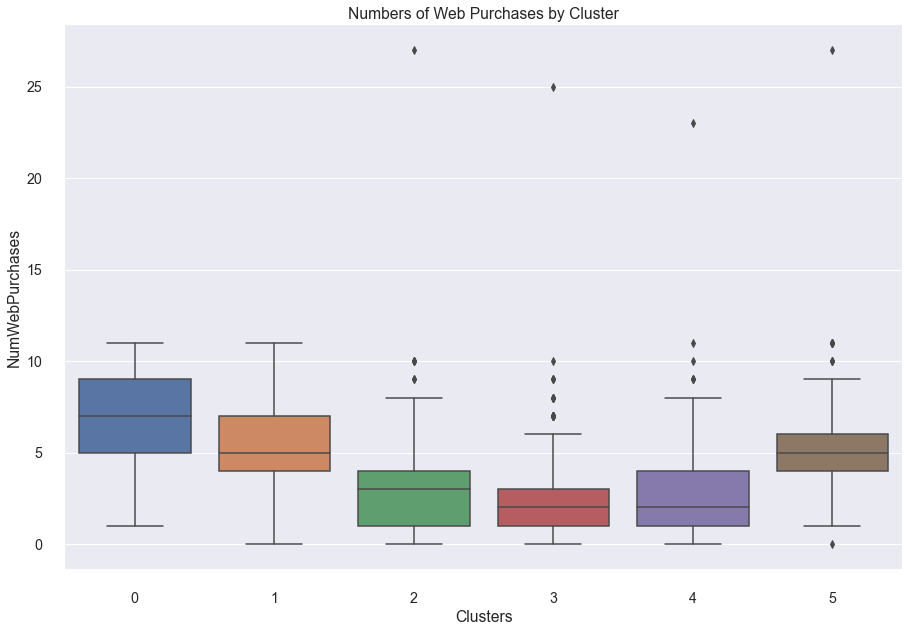

In [54]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Clusters", y="NumWebPurchases",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Web Purchases by Cluster")

plt.savefig('./figures/num_web.png')

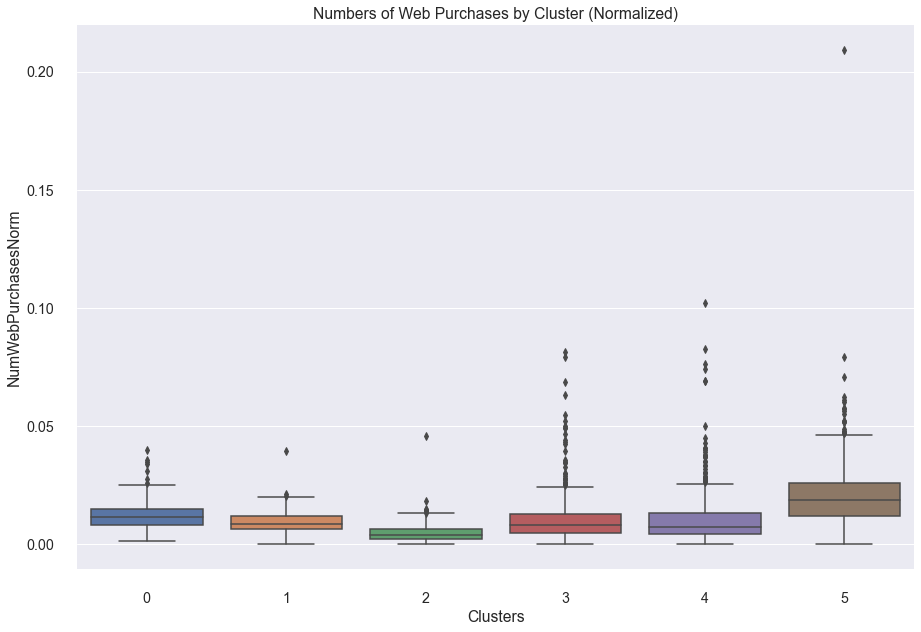

In [55]:
plt.figure(figsize=(15, 10))

sns.boxplot(x="Clusters", y="NumWebPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Web Purchases by Cluster (Normalized)")

plt.savefig('./figures/num_web_norm.png')

- Cluster 0 is the most active on the web overall, followed by Clusters 1 and 5. When normalized, Cluster 5 are the most active on the web.

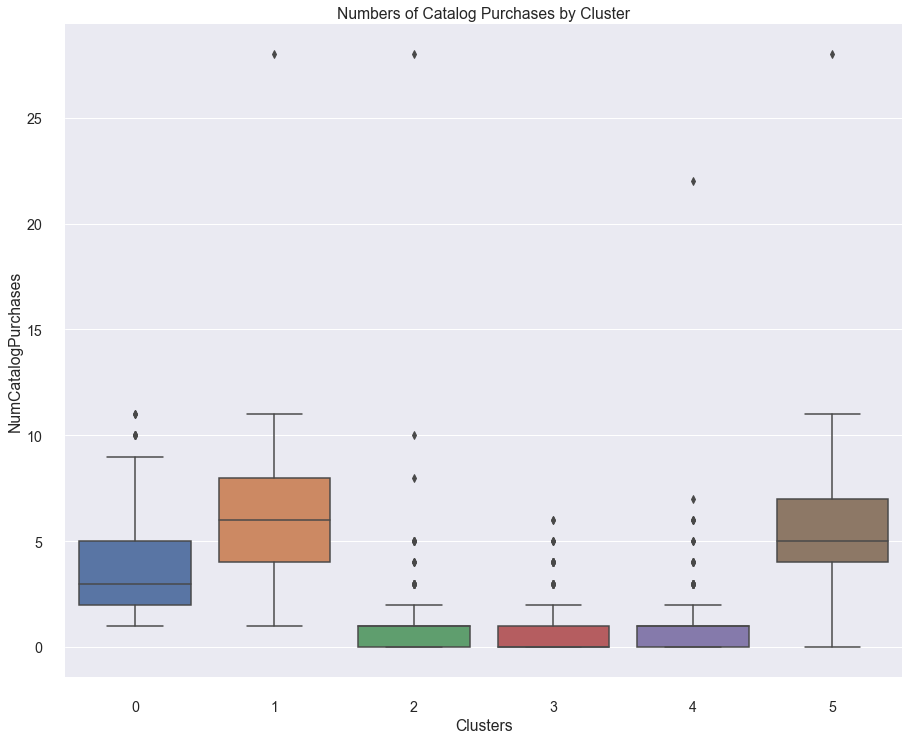

In [56]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumCatalogPurchases",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Catalog Purchases by Cluster")

plt.savefig('./figures/num_catalog.png')

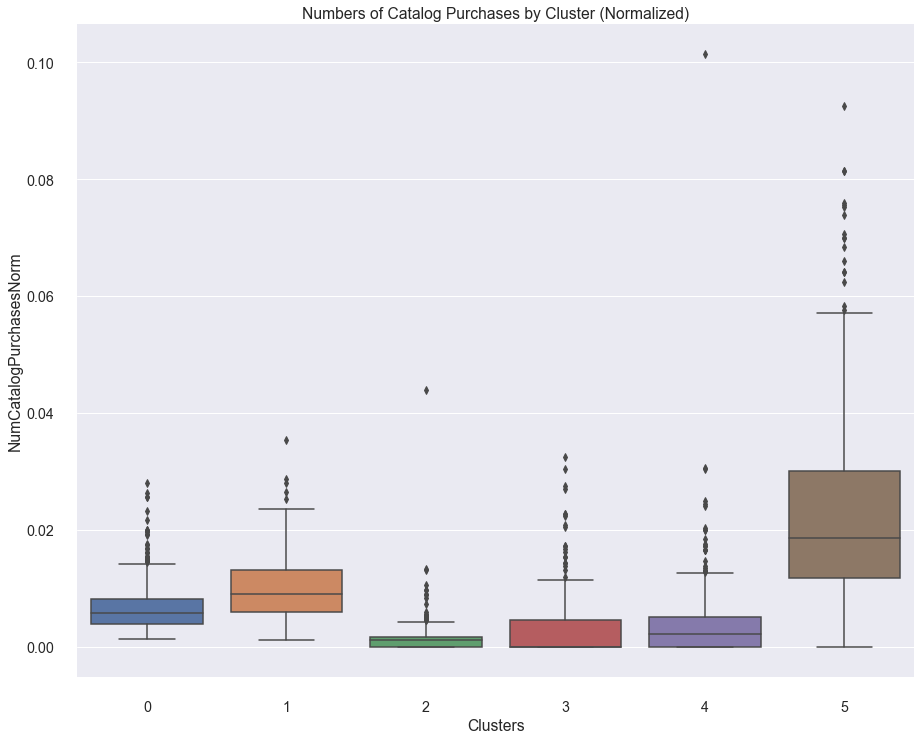

In [57]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumCatalogPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Catalog Purchases by Cluster (Normalized)")

plt.savefig('./figures/num_catalog_norm.png')

- Cluster 5 are the most active catalog users overall, followed by Clusters 1 and 5. When normalized, Cluster 5 are the most active catalog users.

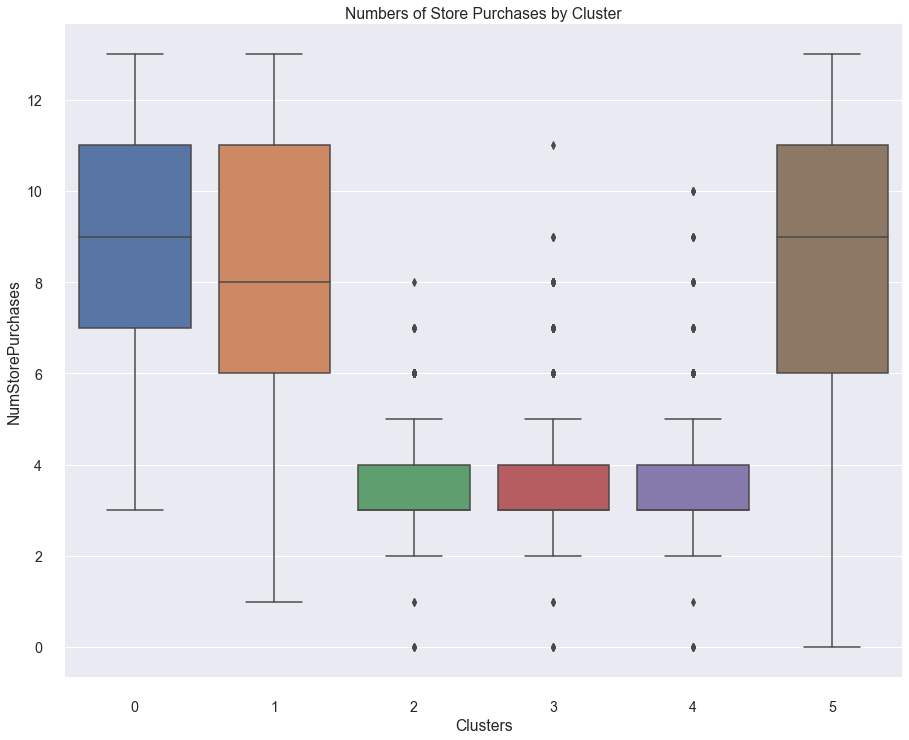

In [58]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumStorePurchases",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Store Purchases by Cluster")

plt.savefig('./figures/num_store.png')

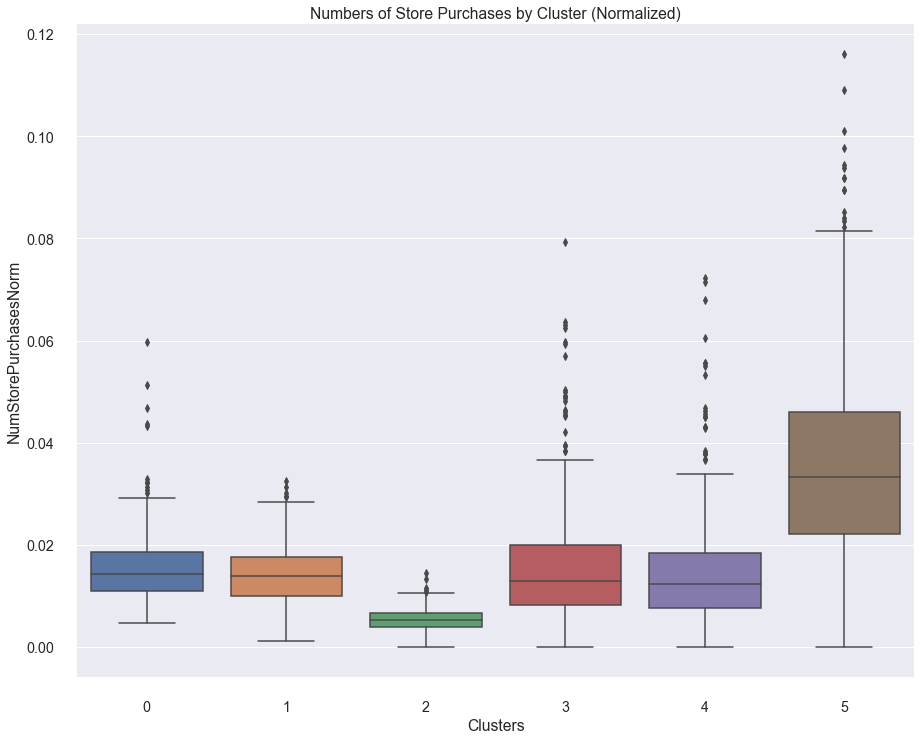

In [59]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumStorePurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Store Purchases by Cluster (Normalized)")

plt.savefig('./figures/num_store_norm.png')

- Both general and aggregated, Cluster 5 customers shop the most in store, followed by Clusters 0 and 1.

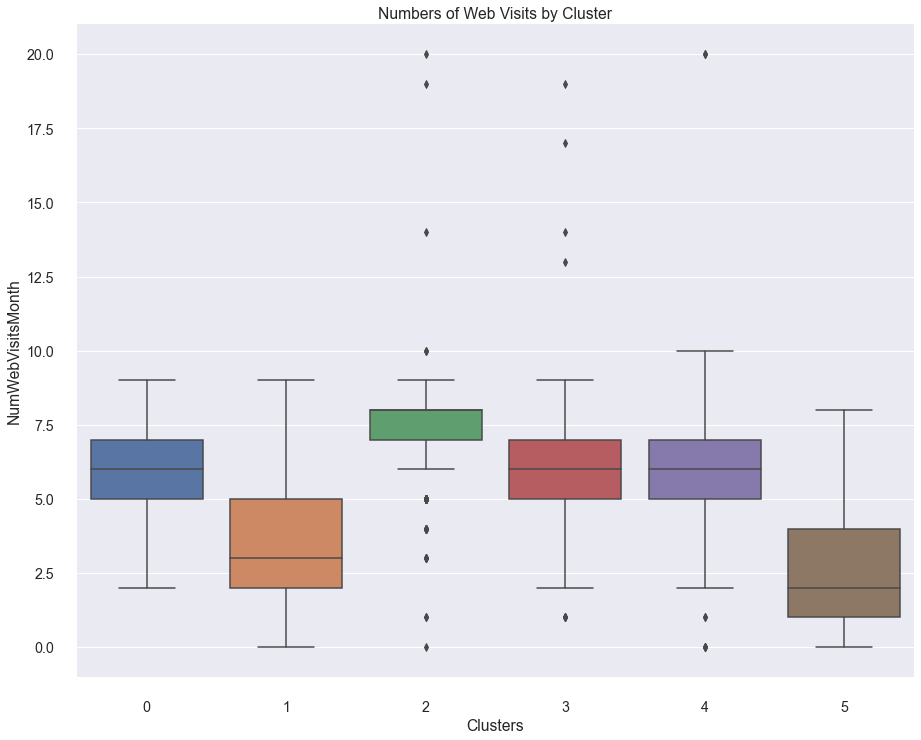

In [59]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumWebVisitsMonth",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Web Visits by Cluster")

plt.savefig('./figures/num_web_visits.png')

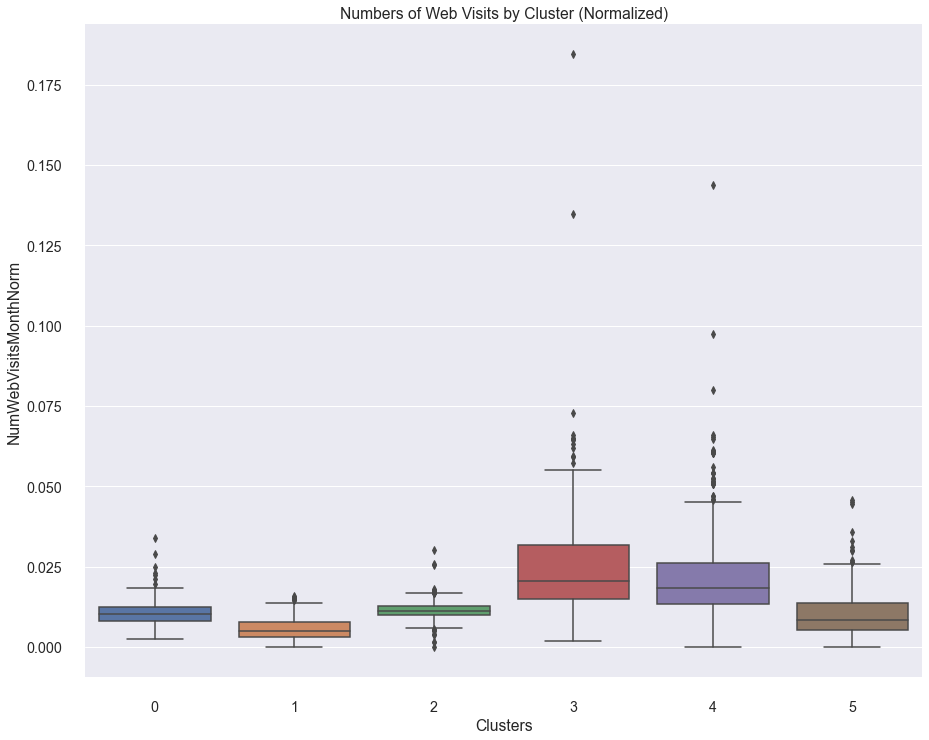

In [60]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumWebVisitsMonthNorm",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Web Visits by Cluster (Normalized)")

plt.savefig('./figures/num_web_visits_norm.png')

- Clusters 2-4 are the most active in browsing the store's web page

#### Some additional explorations (can be skipped)

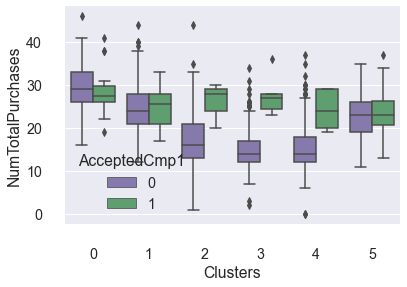

In [62]:
sns.boxplot(x="Clusters", y="NumTotalPurchases",
            hue="AcceptedCmp1", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

In [63]:
### Although 1 spend less than 3 total, their spending normalized by length as customers is much higher!
### Focus on attracting this recent revenue-bringing group

<AxesSubplot:xlabel='Clusters', ylabel='MntSpentNorm'>

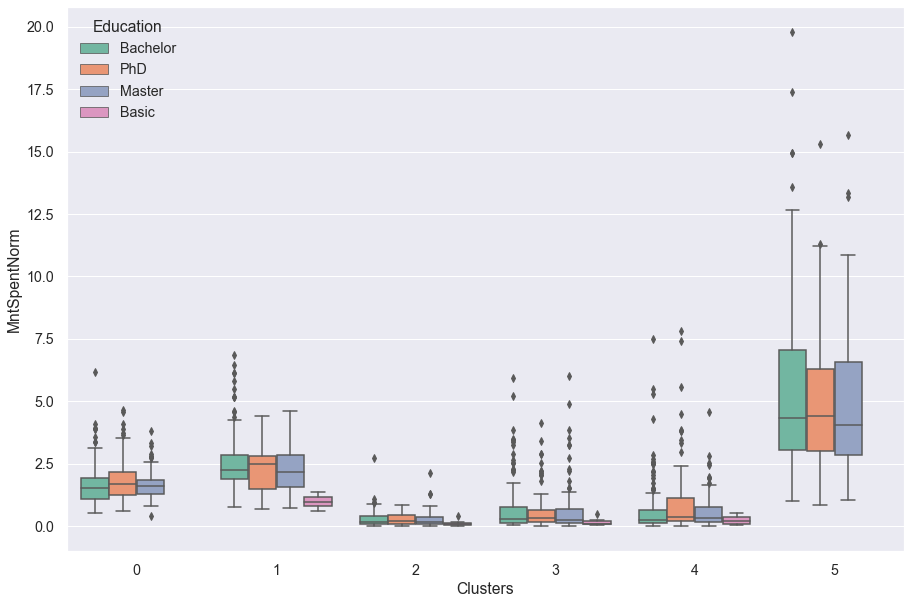

In [64]:
palette=sns.color_palette("Set2")

plt.figure(figsize=(15, 10))
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="Education", palette=palette,
            data=df)

- Overall, higher-educated customers spend more

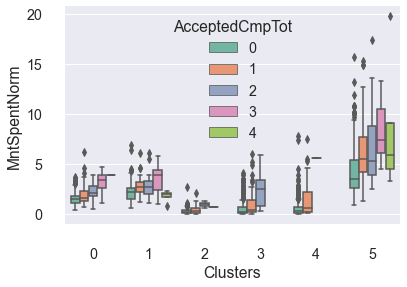

In [65]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

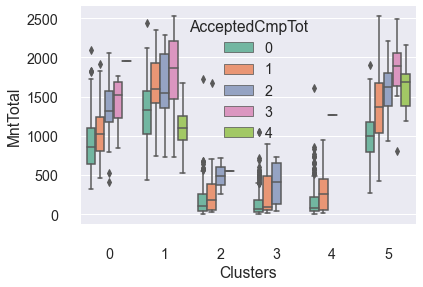

In [66]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

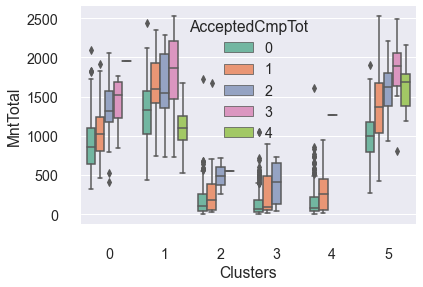

In [67]:
sns.boxplot(x="Clusters", y="MntTotal",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

## Look at campaing effectiveness

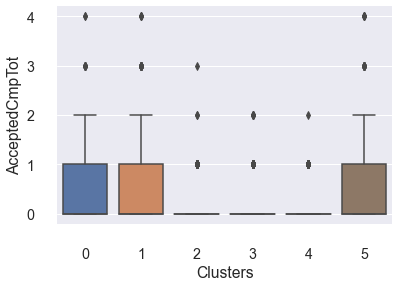

In [68]:
sns.boxplot(x="Clusters", y="AcceptedCmpTot",
            #hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

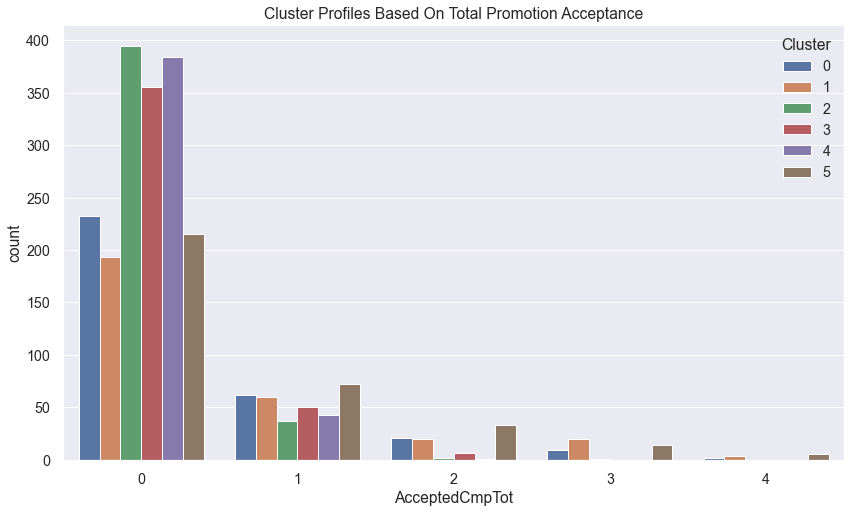

In [69]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmpTot"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Total Promotion Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/num_total_acceptance.png')

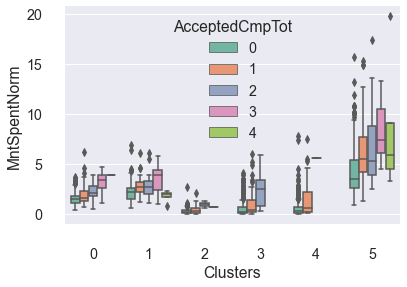

In [70]:
sns.boxplot(x="Clusters", y="MntSpentNorm",
            hue="AcceptedCmpTot", palette=palette,
            data=df)
sns.despine(offset=10, trim=True)
## Cluster 2 spend a lot and accept many promotions

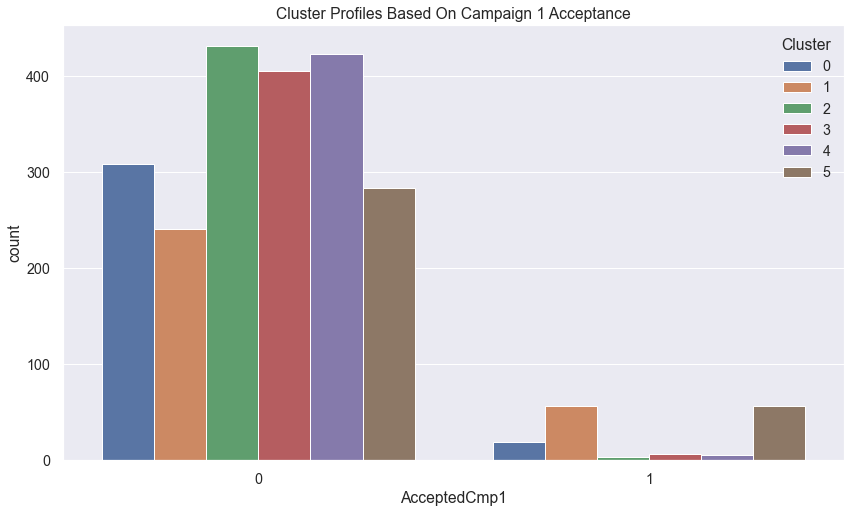

In [71]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp1"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Campaign 1 Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/cmp1_acceptance.png')

- Clusters 1 and 5 responded relatively well to Campaign 1

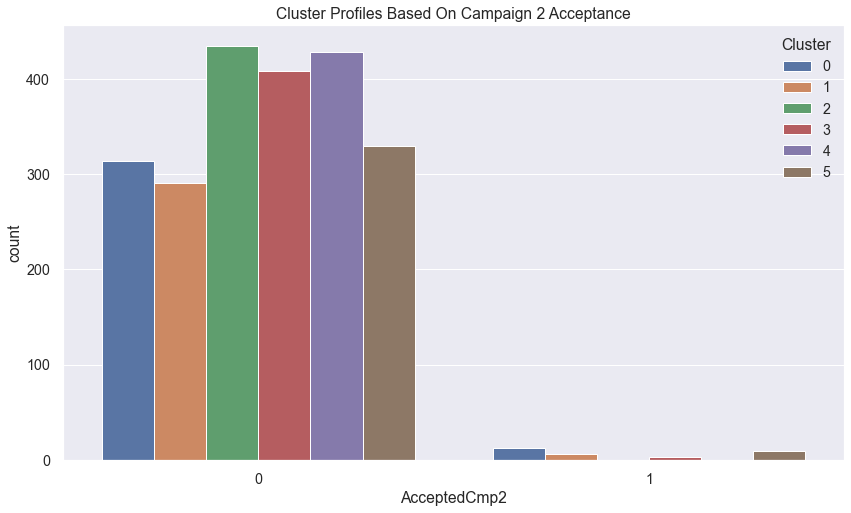

In [72]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp2"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Campaign 2 Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/cmp2_acceptance.png')

- Campaign 2 had a very low response rate

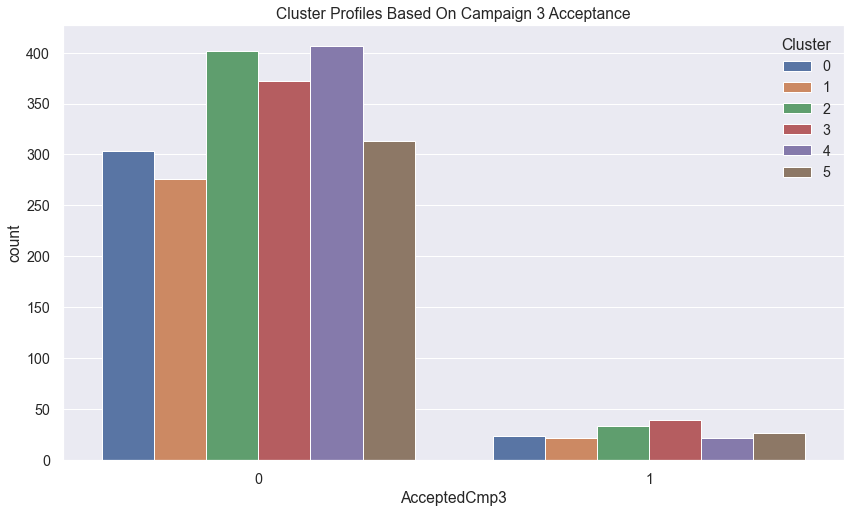

In [73]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp3"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Campaign 3 Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/cmp3_acceptance.png')

- Clusters 2 and 2 responded relatively well to Campaign 3

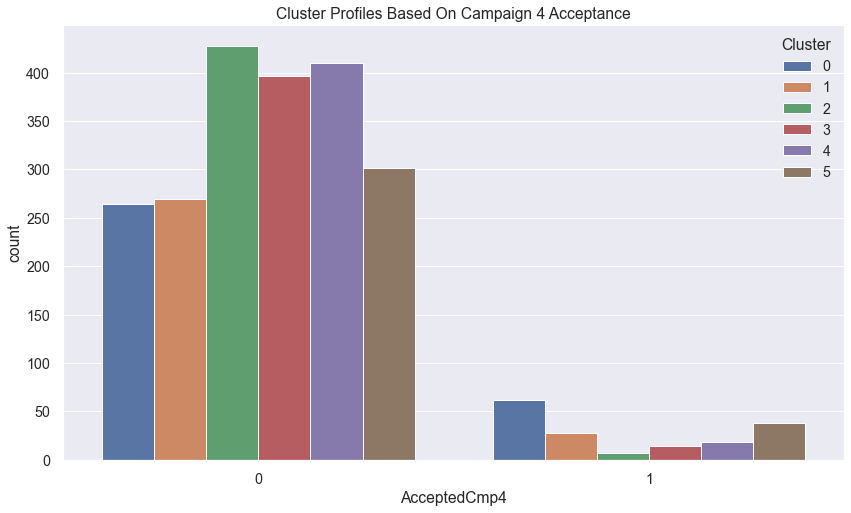

In [74]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp4"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Campaign 4 Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/cmp4_acceptance.png')

- Clusters 0 responded relatively well to Campaign 4

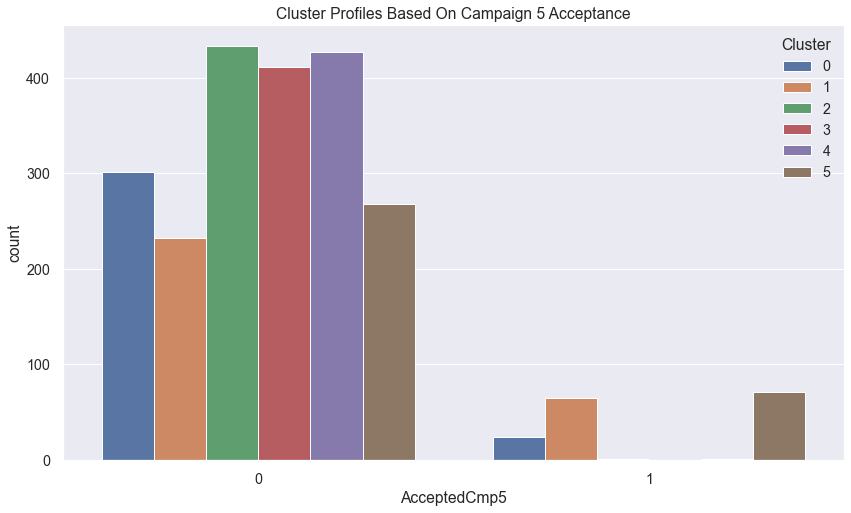

In [75]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["AcceptedCmp5"],hue=df["Clusters"])

plt.title("Cluster Profiles Based On Campaign 5 Acceptance")
plt.legend(title='Cluster',loc=1)
plt.savefig('./figures/cmp5_acceptance.png')

- Clusters 1 and 5 responded relatively well to Campaign 5

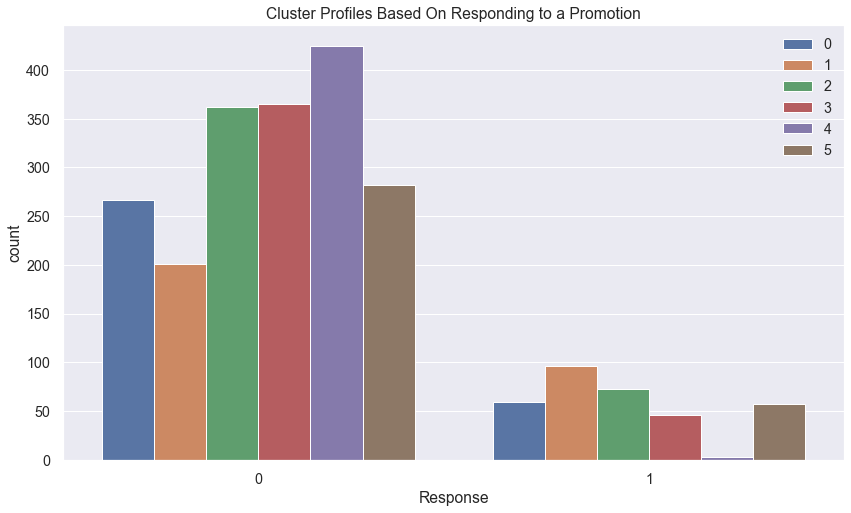

In [76]:
plt.figure(figsize=(14, 8))
#palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.countplot(x=df["Response"],hue=df["Clusters"])

plot.set_title("Cluster Profiles Based On Responding to a Promotion")
plt.legend()
plt.show()

## Additional analyses

### Recency

- **This is unusual, but analyses based on recency seem to be unhelpful. Perhaps 'Recency' was not recorded correctly**

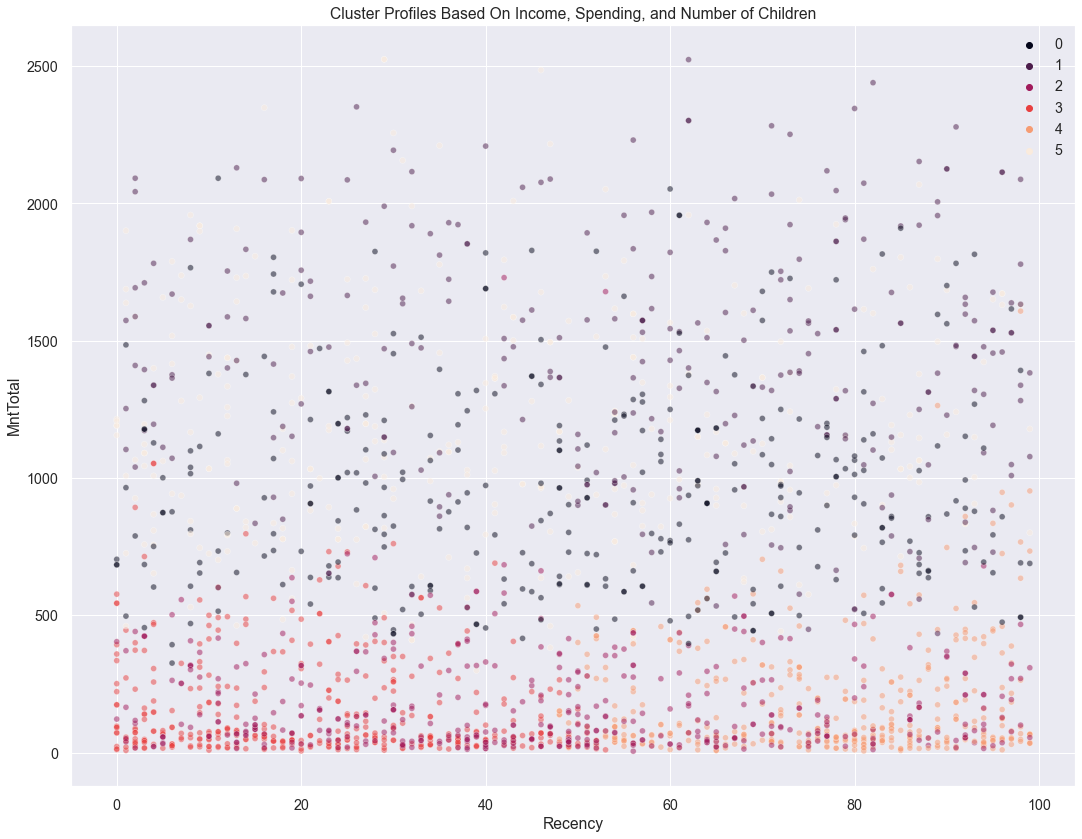

In [81]:
plt.figure(figsize=(18, 14))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Recency"], y=df["MntTotal"],hue=df["Clusters"],alpha=.5,palette=palette)#,style=df['Clusters'])

plot.set_title("Cluster Profiles Based On Income, Spending, and Number of Children")
plt.savefig('./figures/income_mnttotal_child_clusters.pdf')#, bbox_inches='tight')
plt.legend()
plt.show()

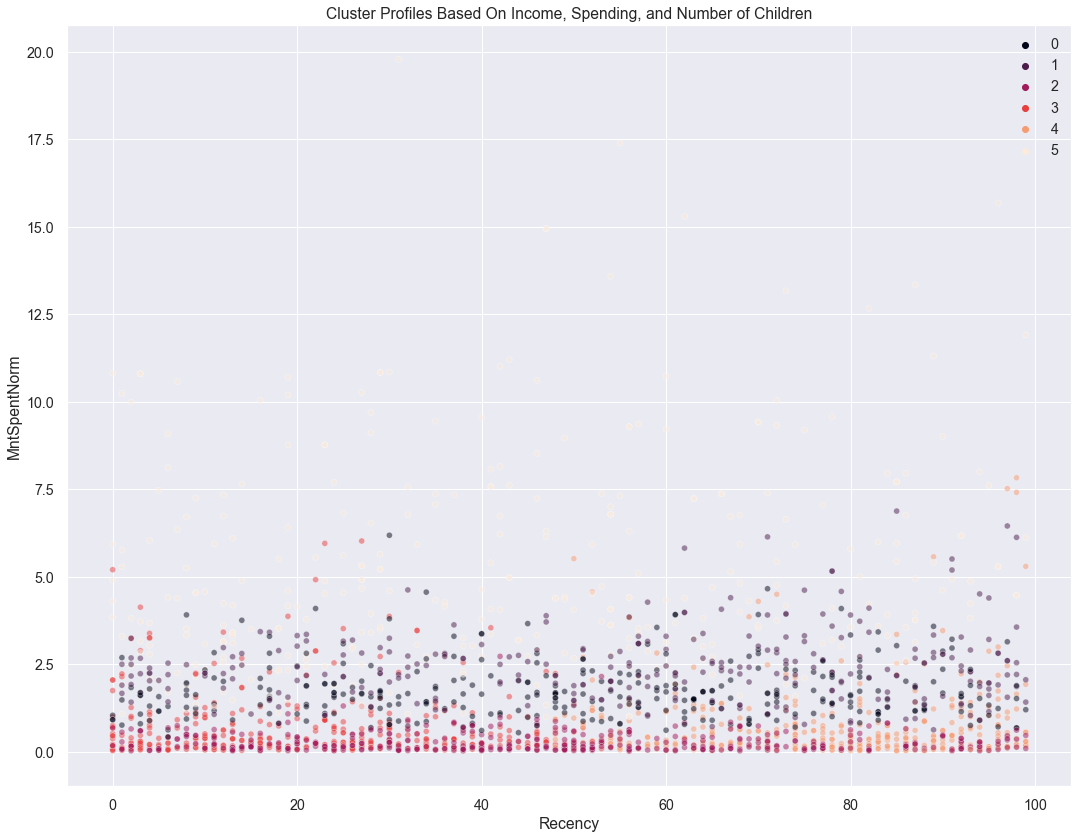

In [85]:
plt.figure(figsize=(18, 14))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Recency"], y=df["MntSpentNorm"],hue=df["Clusters"],alpha=.5,palette=palette)#,style=df['Clusters'])

plot.set_title("Cluster Profiles Based On Income, Spending, and Number of Children")
plt.savefig('./figures/mnttotal_recency.pdf')#, bbox_inches='tight')
plt.legend()
plt.show()

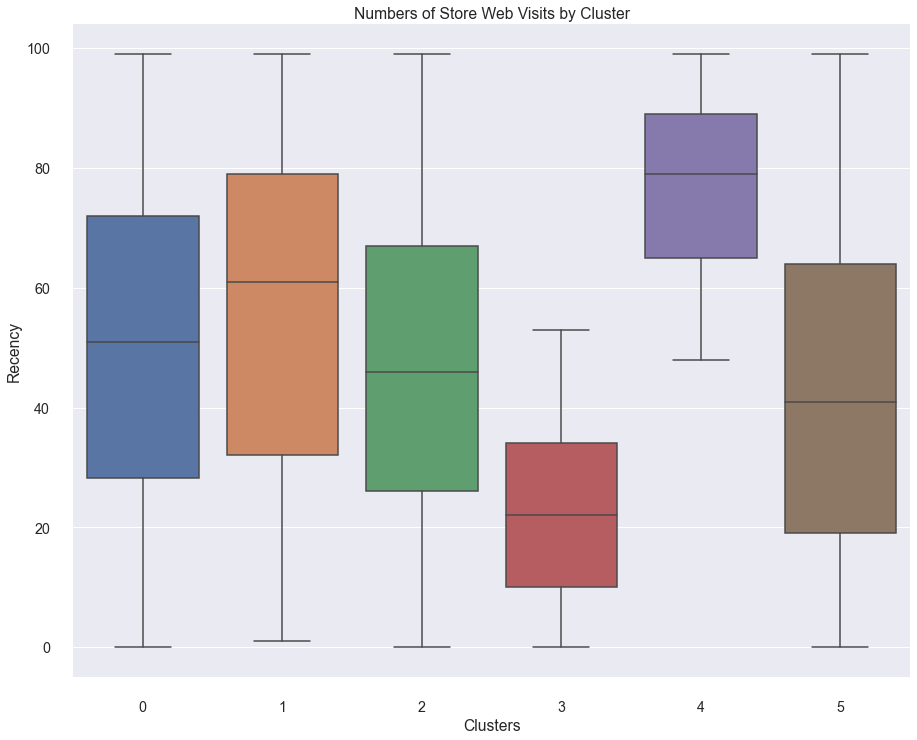

In [84]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="Recency",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Numbers of Store Web Visits by Cluster")

plt.savefig('./figures/recency_box.png')

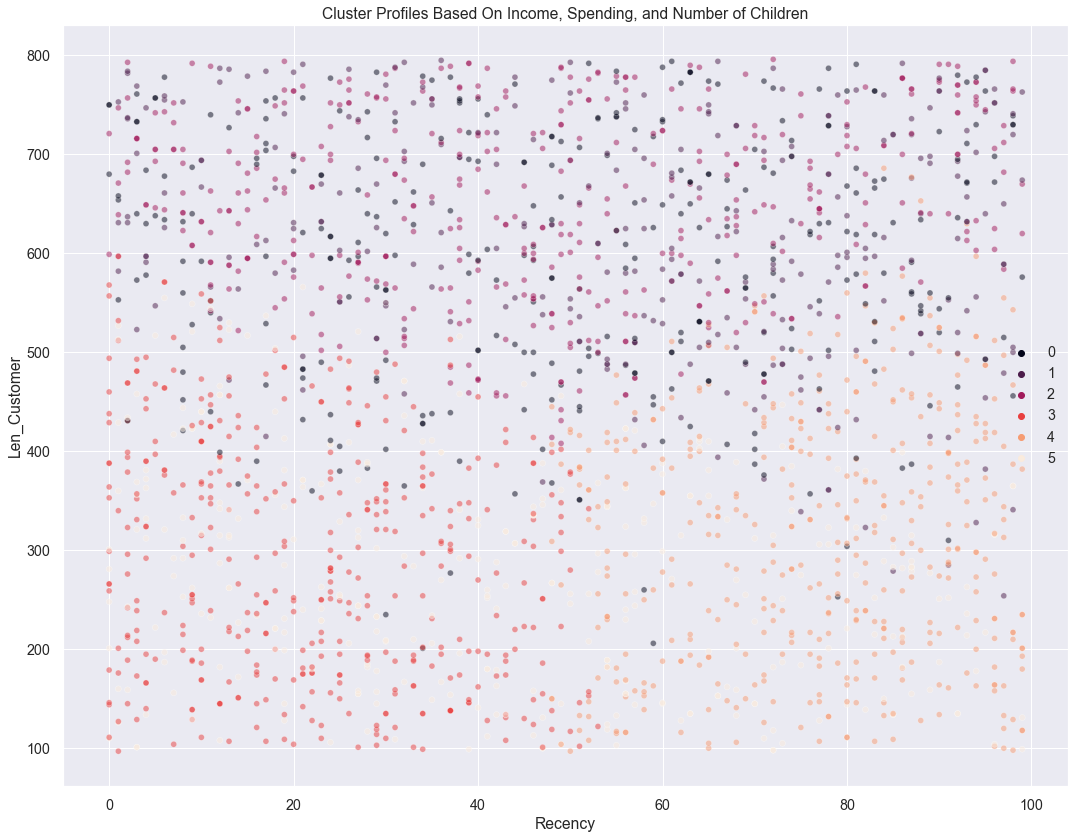

In [87]:
plt.figure(figsize=(18, 14))
palette=sns.color_palette("rocket", as_cmap=True)
plot = sns.scatterplot(data = df,x=df["Recency"], y=df["Len_Customer"],hue=df["Clusters"],alpha=.5,palette=palette)#,style=df['Clusters'])

plot.set_title("Cluster Profiles Based On Income, Spending, and Number of Children")
plt.savefig('./figures/mnttotal_recency.pdf')#, bbox_inches='tight')
plt.legend()
plt.show()

In [88]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country', 'Income',
       'LogIncome', 'NumChildren', 'HasChildren', 'HasPartner', 'age',
       'MntTotal', 'AcceptedCmpTot', 'NumTotalPurchases', 'Len_Customer',
       'MntSpentNorm', 'Clusters', 'MntWinesNorm', 'MntFruitsNorm',
       'MntMeatProductsNorm', 'MntFishProductsNorm', 'MntSweetProductsNorm',
       'MntGoldProdsNorm', 'NumDealsPurchasesNorm', 'NumWebPurchasesNorm',
       'NumStorePurchasesNorm', 'NumWebVisitsMonthNorm',
       'NumCatalogPurchasesNorm'],
      dtype='object')

### Proportion of Income Spent

- What proportion of income do customers spend at the store?

In [119]:
df['SpendPropOfTotal'] = (df['MntTotal']/df['Len_Customer'])/(df['Income']/796) #Daily spending/Daily Income

In [120]:
df=df[df['SpendPropOfTotal']<.1]

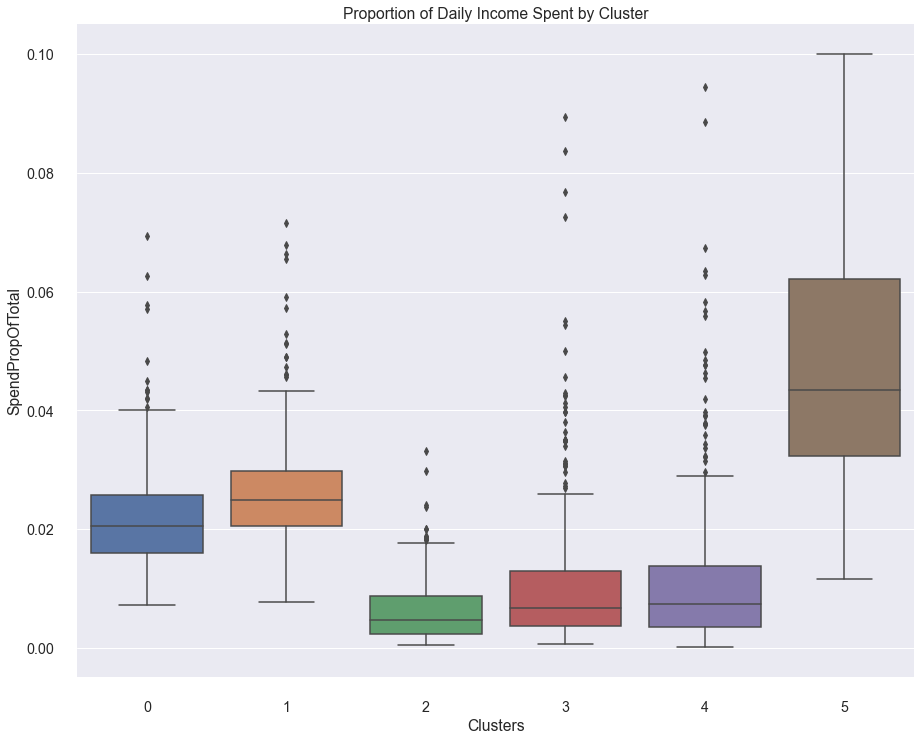

In [122]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="SpendPropOfTotal",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Proportion of Daily Income Spent by Cluster")

plt.savefig('./figures/prop_of_total.png')

- Cluster 5 is still in the lead followed by Clusters 1 and 0. Cluster 5 spends over 4% of their income at the store while Clusters 0 and 1 spend just over 2%. 
- Look for ways to attract customers away from the alternatives.

### Average amount spent per purchase

In [125]:
df['AvgPerPurchase'] = df['MntTotal']/df['NumTotalPurchases']

In [127]:
df=df[df['AvgPerPurchase']<175]

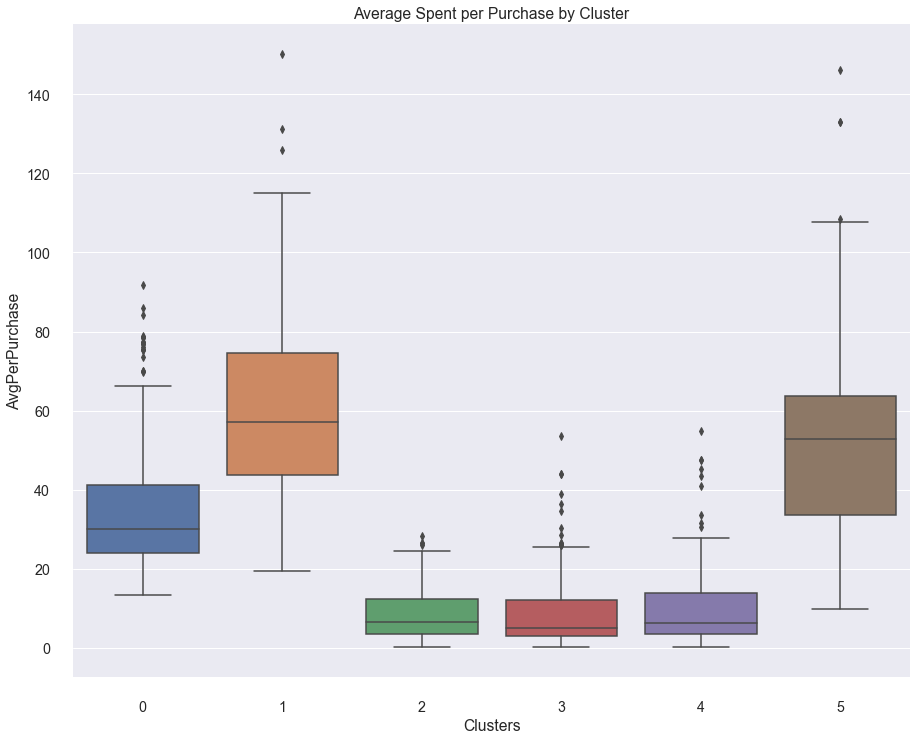

In [128]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="AvgPerPurchase",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Average Spent per Purchase by Cluster")

plt.savefig('./figures/avg_per_purchase.png')

- The median amounts spent per purhase by Clusters 1 and 5 are similar, but Cluster 5 makes more purchases when normalized by length spent as customer

In [131]:
df['NumTotalPurchasesNorm']=df['NumTotalPurchases']/df['Len_Customer']

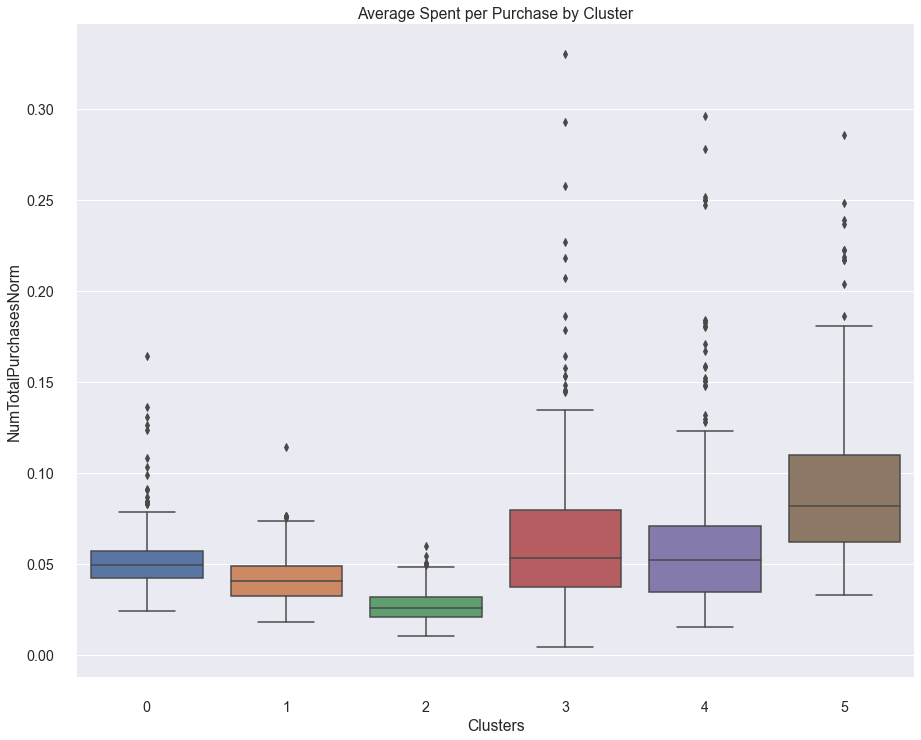

In [133]:
plt.figure(figsize=(15, 12))

sns.boxplot(x="Clusters", y="NumTotalPurchasesNorm",
            data=df)
sns.despine(offset=10, trim=True)

plt.title("Average Spent per Purchase by Cluster")

plt.savefig('./figures/avg_per_purchase.png')